# **HOMEWORK 5**

**Group members:**
* Asia Montico 1966494 - montico.1966494@studenti.uniroma1.it
* Elena Di Grigoli 2011814 - elenadigrigoli@gmail.com
* Recep Yilmaz 2188733 - kamer584@gmail.com
* Angelica Zauner 1883247 - zauner.1883247@studenti.uniroma1.it

#### **Import and dataset**

In [ ]:
pip install kagglehub==0.3.6


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.5
    Uninstalling kagglehub-0.3.5:
      Successfully uninstalled kagglehub-0.3.5


In [ ]:
import kagglehub
import os
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import time
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from joblib import Parallel, delayed
from IPython.display import display, HTML, IFrame
from folium import Map, PolyLine, Marker, Icon
from folium.plugins import MarkerCluster
from tqdm import tqdm
from branca.colormap import LinearColormap
import branca.colormap as cm

pio.renderers.default = "notebook"

# Import the dataset and create DataFrame
path = kagglehub.dataset_download("flashgordon/usa-airport-dataset")
csv_file = os.path.join(path, "Airports2.csv")
df = pd.read_csv(csv_file)
dataset = pd.read_csv(csv_file)


100%|██████████| 40.8M/40.8M [00:00<00:00, 57.0MB/s]

Extracting files...


In [ ]:
df.head()

Origin_airport Destination_airport    Origin_city Destination_city  \
0            MHK                 AMW  Manhattan, KS         Ames, IA   
1            EUG                 RDM     Eugene, OR         Bend, OR   
2            EUG                 RDM     Eugene, OR         Bend, OR   
3            EUG                 RDM     Eugene, OR         Bend, OR   
4            MFR                 RDM    Medford, OR         Bend, OR   

   Passengers  Seats  Flights  Distance    Fly_date  Origin_population  \
0          21     30        1       254  2008-10-01             122049   
1          41    396       22       103  1990-11-01             284093   
2          88    342       19       103  1990-12-01             284093   
3          11     72        4       103  1990-10-01             284093   
4           0     18        1       156  1990-02-01             147300   

   Destination_population  Org_airport_lat  Org_airport_long  \
0                   86219        39.140999        -96.670799   
1                   76034        44.124599       -123.211998   
2                   76034        44.124599       -123.211998   
3                   76034        44.124599       -123.211998   
4                   76034        42.374199       -122.873001   

   Dest_airport_lat  Dest_airport_long  
0               NaN                NaN  
1         44.254101        -121.150002  
2         44.254101        -121.150002  
3         44.254101        -121.150002  
4         44.254101        -121.150002

## **1. Flight Network Analysis (Q1)**



### **Task 1.1.1. - Count Nodes and Edges**
This code calculates the total number of airports (nodes) and flights (edges) in the given flight network. The input `flight_network` is assumed to be a dictionary or a data structure where:
- Keys represent the source airports.
- Values represent a list of destination airports for each source.

The code iterates through this structure to count:
1. **Nodes**: Unique airports from both keys (sources) and values (destinations).
2. **Edges**: Total number of flights by summing all the destination lists.

The results are returned as a tuple `(number_of_nodes, number_of_edges)`.


Total Number of Nodes: 727
Total Number of Edges: 36719


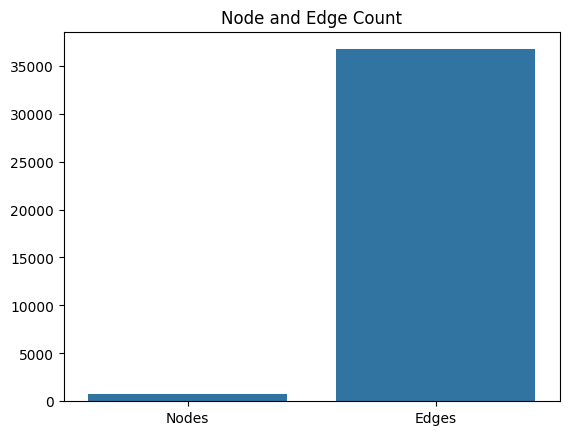

In [ ]:
def compute_graph_density(num_nodes, num_edges):
    """
    Computes the density of a graph.

    Parameters:
        num_nodes (int): Number of nodes.
        num_edges (int): Number of edges.

    Returns:
        float: Graph density.
    """
    if num_nodes <= 1:
        return 0.0
    return (2 * num_edges) / (num_nodes * (num_nodes - 1))
def count_nodes_and_edges(data):
    """
    Accurately calculates the number of nodes (airports) and edges (flights) in the dataset.

    Parameters:
        data (pd.DataFrame): Dataset (should include Origin_airport and Destination_airport columns).

    Returns:
        tuple: (number of nodes, number of edges)
    """
    # Calculate nodes (unique airports)
    nodes = set(data['Origin_airport']).union(data['Destination_airport'])

    # Calculate edges (unique Origin-Destination pairs)
    edges = len(data[['Origin_airport', 'Destination_airport']].drop_duplicates())

    # Print output
    print(f"Total Number of Nodes: {len(nodes)}")
    print(f"Total Number of Edges: {edges}")

    return len(nodes), edges


# Calculate nodes and edges from the dataset
nodes, edges = count_nodes_and_edges(dataset)
# Calculate graph density
density = compute_graph_density(nodes, edges)
sns.barplot(x=["Nodes", "Edges"], y=[nodes, edges])
plt.title("Node and Edge Count")
plt.show()


#### **Explanation:**
- **Nodes Calculation**: The union of keys and values ensures that all airports, both sources and destinations, are counted as unique nodes.
- **Edges Calculation**: The total number of edges is the sum of the lengths of all destination lists, which corresponds to the number of direct flights.

This function assumes that the flight network is represented as a dictionary where each key points to a list of destinations.


### **Task 1.1.2. - Compute Graph Density**
This code computes the density of the flight network using the formula:

$$
\text{Density} = \frac{2 \cdot E}{N \cdot (N-1)}
$$

Where:
- \( $N$ \) is the number of nodes (airports).
- \( $E$ \) is the number of edges (flights).

The formula measures how connected the graph is, relative to the maximum number of possible connections. The result is a value between 0 (no connections) and 1 (fully connected). The code assumes the number of nodes and edges are already calculated.


In [ ]:
def compute_graph_density(num_nodes, num_edges):
    """
    Calculates the density of a graph.

    Parameters:
        num_nodes (int): Number of nodes.
        num_edges (int): Number of edges.

    Returns:
        float: Graph density.
    """
    # Check for negative values
    if num_nodes < 0 or num_edges < 0:
        raise ValueError("The number of nodes and edges cannot be negative.")

    # Single-node graph check
    if num_nodes <= 1:
        return 0.0

    # Calculate density
    density = (2 * num_edges) / (num_nodes * (num_nodes - 1))
    print(f"Graph Density: {density:.4f}")

    return density


# Example usage
density = compute_graph_density(727, 36719)


Graph Density: 0.1391


### **Task 1.1.3. - In-Degree and Out-Degree Calculation with Visualization**
This task involves calculating:
1. **In-Degree**: Number of incoming flights for each airport.
2. **Out-Degree**: Number of outgoing flights for each airport.

The results are visualized using histograms:
- The x-axis represents the degree (number of flights).
- The y-axis represents the count of airports with that degree.

This task assumes the `flight_network` is a dictionary where:
- Keys represent source airports.
- Values represent lists of destination airports.
The in-degree and out-degree for each airport are calculated using dictionary-based aggregation.


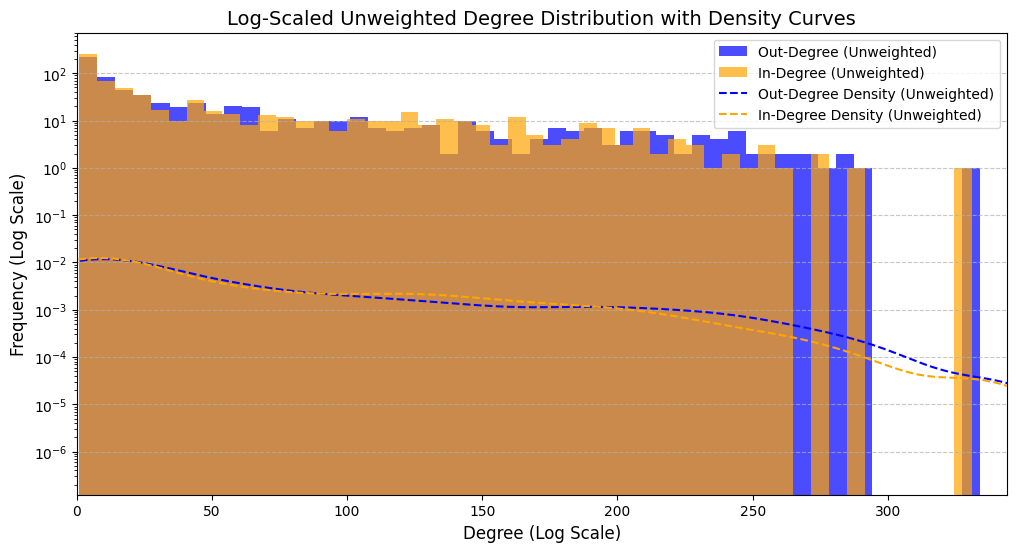

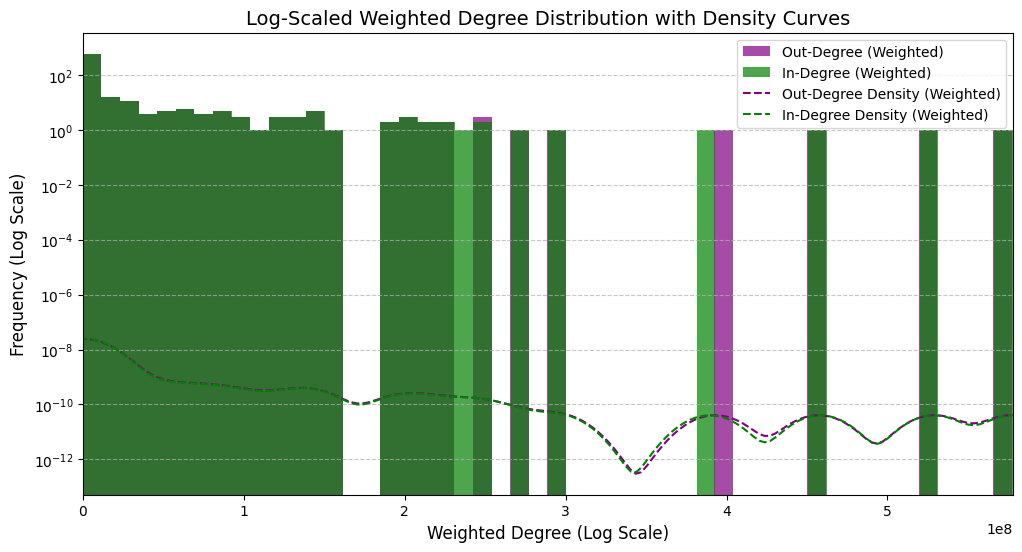

=== Top Airports by Degree ===

Top 5 Airports by Out-Degree (Unweighted):
[('YIP', 334), ('MSP', 292), ('MEM', 287), ('ORD', 286), ('ATL', 280)]

Top 5 Airports by Out-Degree (Weighted):
Origin_airport
ATL    577124268
ORD    529018110
DFW    457153720
LAX    393005676
PHX    295857703
Name: Passengers, dtype: int64

=== Unweighted Degrees ===
Out-Degree (Unweighted) - Min: 1, Max: 334, Avg: 53.76
In-Degree (Unweighted) - Min: 1, Max: 331, Avg: 51.86

=== Weighted Degrees ===
Out-Degree (Weighted) - Min: 0, Max: 577124268, Avg: 14199663.57
In-Degree (Weighted) - Min: 0, Max: 577954147, Avg: 13698263.02


In [ ]:
def calculate_degrees_and_visualize_combined(data):
    """
    Calculates in-degree and out-degree metrics (weighted and unweighted) and provides advanced visualizations.

    Parameters:
        data (pd.DataFrame): Dataset (must include 'Origin_airport', 'Destination_airport', and 'Passengers' columns).

    Returns:
        tuple: (in-degree unweighted dictionary, out-degree unweighted dictionary,
                in-degree weighted series, out-degree weighted series)
    """
    from collections import Counter
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # 1. Unweighted Degrees
    unique_edges = data[['Origin_airport', 'Destination_airport']].drop_duplicates()
    out_degree_unweighted = Counter(unique_edges['Origin_airport'])
    in_degree_unweighted = Counter(unique_edges['Destination_airport'])

    # 2. Weighted Degrees (flight frequencies by passenger count)
    out_degree_weighted = data.groupby('Origin_airport')['Passengers'].sum()
    in_degree_weighted = data.groupby('Destination_airport')['Passengers'].sum()

    # 3. Visualization - Unweighted Degrees
    plt.figure(figsize=(12, 6))
    colors = {"out_degree_unweighted": "blue", "in_degree_unweighted": "orange"}
    plt.hist(out_degree_unweighted.values(), bins=50, alpha=0.7, label="Out-Degree (Unweighted)", color=colors["out_degree_unweighted"], log=True)
    plt.hist(in_degree_unweighted.values(), bins=50, alpha=0.7, label="In-Degree (Unweighted)", color=colors["in_degree_unweighted"], log=True)
    sns.kdeplot(list(out_degree_unweighted.values()), label="Out-Degree Density (Unweighted)", color=colors["out_degree_unweighted"], linestyle="--")
    sns.kdeplot(list(in_degree_unweighted.values()), label="In-Degree Density (Unweighted)", color=colors["in_degree_unweighted"], linestyle="--")
    plt.title("Log-Scaled Unweighted Degree Distribution with Density Curves", fontsize=14)
    plt.xlabel("Degree (Log Scale)", fontsize=12)
    plt.ylabel("Frequency (Log Scale)", fontsize=12)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xlim(0, max(max(out_degree_unweighted.values()), max(in_degree_unweighted.values())) + 10)
    plt.show()

    # 4. Visualization - Weighted Degrees
    plt.figure(figsize=(12, 6))
    colors = {"out_degree_weighted": "purple", "in_degree_weighted": "green"}
    plt.hist(out_degree_weighted.values, bins=50, alpha=0.7, label="Out-Degree (Weighted)", color=colors["out_degree_weighted"], log=True)
    plt.hist(in_degree_weighted.values, bins=50, alpha=0.7, label="In-Degree (Weighted)", color=colors["in_degree_weighted"], log=True)
    sns.kdeplot(out_degree_weighted.values, label="Out-Degree Density (Weighted)", color=colors["out_degree_weighted"], linestyle="--")
    sns.kdeplot(in_degree_weighted.values, label="In-Degree Density (Weighted)", color=colors["in_degree_weighted"], linestyle="--")
    plt.title("Log-Scaled Weighted Degree Distribution with Density Curves", fontsize=14)
    plt.xlabel("Weighted Degree (Log Scale)", fontsize=12)
    plt.ylabel("Frequency (Log Scale)", fontsize=12)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xlim(0, max(out_degree_weighted.max(), in_degree_weighted.max()) + 10)
    plt.show()

    # 5. Top Airports by Degree
    print("=== Top Airports by Degree ===")
    print("\nTop 5 Airports by Out-Degree (Unweighted):")
    print(out_degree_unweighted.most_common(5))

    print("\nTop 5 Airports by Out-Degree (Weighted):")
    print(out_degree_weighted.nlargest(5))

    # 6. Statistical Summaries
    print("\n=== Unweighted Degrees ===")
    print(f"Out-Degree (Unweighted) - Min: {min(out_degree_unweighted.values())}, Max: {max(out_degree_unweighted.values())}, Avg: {np.mean(list(out_degree_unweighted.values())):.2f}")
    print(f"In-Degree (Unweighted) - Min: {min(in_degree_unweighted.values())}, Max: {max(in_degree_unweighted.values())}, Avg: {np.mean(list(in_degree_unweighted.values())):.2f}")

    print("\n=== Weighted Degrees ===")
    print(f"Out-Degree (Weighted) - Min: {out_degree_weighted.min()}, Max: {out_degree_weighted.max()}, Avg: {out_degree_weighted.mean():.2f}")
    print(f"In-Degree (Weighted) - Min: {in_degree_weighted.min()}, Max: {in_degree_weighted.max()}, Avg: {in_degree_weighted.mean():.2f}")

    return in_degree_unweighted, out_degree_unweighted, in_degree_weighted, out_degree_weighted


# Calculate and visualize the combined degree metrics
in_degrees_unweighted, out_degrees_unweighted, in_degrees_weighted, out_degrees_weighted = calculate_degrees_and_visualize_combined(dataset)


### **Task 1.1.4. - Identify Hubs**
This code identifies airports with degrees (both in-degree and out-degree) higher than the 90th percentile, labeling them as "hubs." The process involves:
1. Calculating in-degree and out-degree for all airports.
2. Determining the 90th percentile thresholds for both in-degree and out-degree.
3. Identifying airports exceeding these thresholds.
4. Combining results into a comprehensive list of "hubs."

The output is a dictionary with two keys:
- `in_degree_hubs`: Airports with in-degree higher than the 90th percentile.
- `out_degree_hubs`: Airports with out-degree higher than the 90th percentile.


In-Degree Hubs (Top 5): ['MIA', 'OMA', 'TPA', 'TUL', 'AUS']...
Out-Degree Hubs (Top 5): ['SEA', 'PDX', 'SFO', 'LAX', 'FLL']...
Total In-Degree Hubs: 71
Total Out-Degree Hubs: 66
Hubs in Both In-Degree and Out-Degree: 61


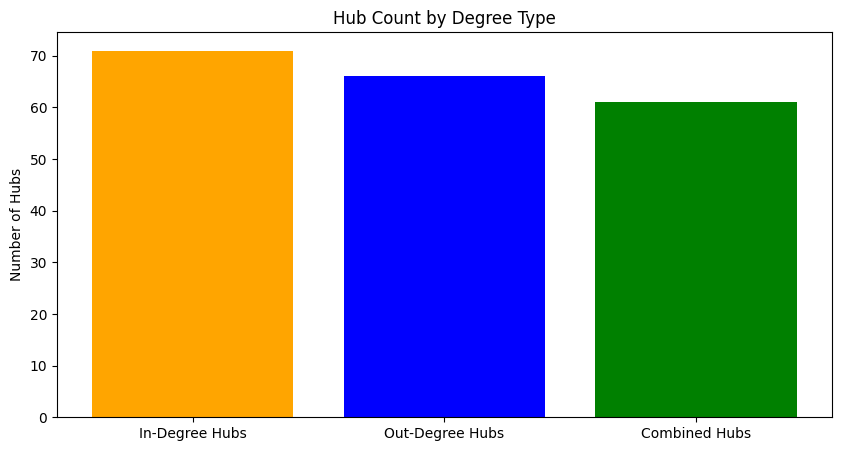

In [ ]:
def identify_hubs(in_degree, out_degree):
    """
    Identifies airports with degrees above the 90th percentile as hubs.

    Parameters:
        in_degree (dict): Dictionary of in-degrees for airports.
        out_degree (dict): Dictionary of out-degrees for airports.

    Returns:
        dict: A dictionary containing lists of in-degree hubs, out-degree hubs, and combined hubs.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Calculate 90th percentile thresholds
    in_degree_threshold = np.percentile(list(in_degree.values()), 90)
    out_degree_threshold = np.percentile(list(out_degree.values()), 90)

    # Identify hubs
    in_degree_hubs = [airport for airport, degree in in_degree.items() if degree > in_degree_threshold]
    out_degree_hubs = [airport for airport, degree in out_degree.items() if degree > out_degree_threshold]

    # Find common hubs
    combined_hubs = set(in_degree_hubs) & set(out_degree_hubs)

    # Print results
    print(f"In-Degree Hubs (Top 5): {in_degree_hubs[:5]}...")  # Show first 5 as an example
    print(f"Out-Degree Hubs (Top 5): {out_degree_hubs[:5]}...")  # Show first 5 as an example
    print(f"Total In-Degree Hubs: {len(in_degree_hubs)}")
    print(f"Total Out-Degree Hubs: {len(out_degree_hubs)}")
    print(f"Hubs in Both In-Degree and Out-Degree: {len(combined_hubs)}")

    # Visualization
    plt.figure(figsize=(10, 5))
    plt.bar(
        ["In-Degree Hubs", "Out-Degree Hubs", "Combined Hubs"],
        [len(in_degree_hubs), len(out_degree_hubs), len(combined_hubs)],
        color=["orange", "blue", "green"]
    )
    plt.title("Hub Count by Degree Type")
    plt.ylabel("Number of Hubs")
    plt.show()

    return {
        "in_degree_hubs": in_degree_hubs,
        "out_degree_hubs": out_degree_hubs,
        "combined_hubs": list(combined_hubs)
    }


# Identify hubs
hubs = identify_hubs(in_degrees_unweighted, out_degrees_unweighted)


### **Task 1.1.5. - Determine if the Graph is Sparse or Dense**
This code determines whether the flight network graph is sparse or dense based on its density. A graph is considered:
- **Sparse** if the density is much closer to 0, meaning it has relatively few edges compared to the maximum possible number of edges.
- **Dense** if the density is closer to 1, meaning it has a large number of edges.

The threshold for determining sparsity vs. density is subjective, but for simplicity:
- $If$ \( $\text{Density} < 0.1 $\), the graph is labeled "Sparse."
- Otherwise, it is labeled "Dense."


Graph Density: 0.1391
Graph Type Based on Density: Moderately Dense (Density: 0.1391)


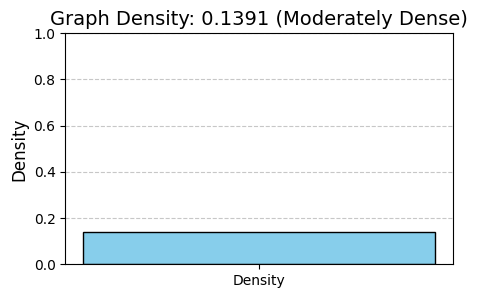

In [ ]:
def determine_and_visualize_graph_density(density, threshold=0.1):
    """
    Determines whether the graph is sparse or dense based on its density
    and visualizes the density.

    Parameters:
        density (float): The density of the graph.
        threshold (float): The threshold for categorizing density (default: 0.1).

    Returns:
        str: Classification of the graph as "Very Sparse", "Sparse",
             "Moderately Dense", or "Dense".
    """
    import matplotlib.pyplot as plt

    # Classify the graph based on density thresholds
    if density < 0.01:
        graph_type = "Very Sparse"
    elif density < threshold:
        graph_type = "Sparse"
    elif density < 0.5:
        graph_type = "Moderately Dense"
    else:
        graph_type = "Dense"

    print(f"Graph Type Based on Density: {graph_type} (Density: {density:.4f})")

    # Visualization of graph density
    plt.figure(figsize=(5, 3))
    plt.bar(["Density"], [density], color="skyblue", edgecolor="black")
    plt.title(f"Graph Density: {density:.4f} ({graph_type})", fontsize=14)
    plt.ylim(0, 1)
    plt.ylabel("Density", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    return graph_type


# Compute graph density
density = compute_graph_density(nodes, edges)

# Determine and visualize the graph density
graph_type = determine_and_visualize_graph_density(density)


### **Task 1.2.1. - Summarize Number of Nodes and Edges**
This function, `summarize_graph_features`, generates a detailed report about the flight network's features, starting with the number of nodes and edges. The report aggregates key metrics such as:
1. Total number of airports (nodes).
2. Total number of flights (edges).

This specific step focuses on reporting these counts as part of the summary. The function uses previously defined `count_nodes_and_edges` to extract these values.


### **Task 1.2.2. - Include Graph Density in the Summary**
This step expands the `summarize_graph_features` function to include the graph density in the summary report. It uses the previously defined `compute_graph_density` function to calculate the density based on the number of nodes and edges. The density value is then added to the summary dictionary.


Graph Type Based on Density: Moderately Dense (Density: 0.1391)


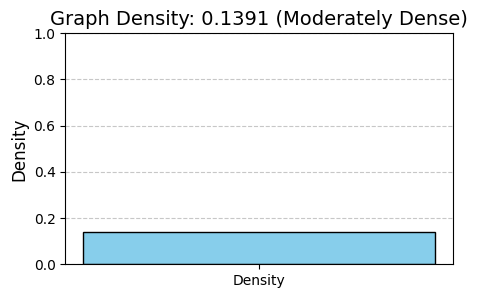


Graph Summary:
                                       Value
Number of Nodes (Airports)               727
Number of Edges (Flights)              36719
Graph Density                       0.139139
Graph Type                  Moderately Dense


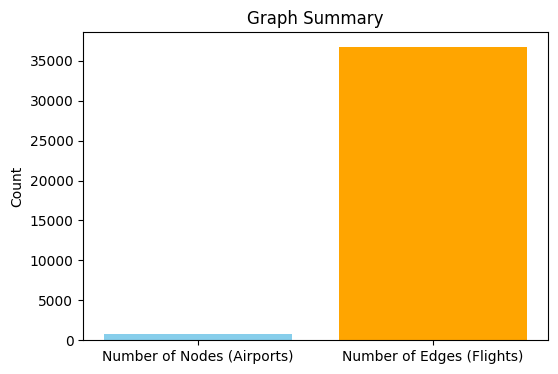

In [ ]:
def summarize_and_visualize_graph(flight_network):
    """
    Generates a summary report of graph features, including density, and visualizes the summary.

    Parameters:
        flight_network (pd.DataFrame): Dataset (must include 'Origin_airport' and 'Destination_airport' columns).

    Returns:
        dict: A summary of graph features and density.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Calculate the number of nodes and edges
    num_nodes, num_edges = count_nodes_and_edges(flight_network)

    # Calculate graph density
    density = compute_graph_density(num_nodes, num_edges)

    # Determine graph type and visualize density
    graph_type = determine_and_visualize_graph_density(density)

    # Create summary report
    summary = {
        "Number of Nodes (Airports)": num_nodes,
        "Number of Edges (Flights)": num_edges,
        "Graph Density": density,
        "Graph Type": graph_type
    }

    # Print the summary in a user-friendly format
    summary_df = pd.DataFrame.from_dict(summary, orient="index", columns=["Value"])
    print("\nGraph Summary:")
    print(summary_df)

    # Visualize the node and edge counts
    keys = ["Number of Nodes (Airports)", "Number of Edges (Flights)"]
    values = [summary[key] for key in keys]

    plt.figure(figsize=(6, 4))
    plt.bar(keys, values, color=["skyblue", "orange"])
    plt.title("Graph Summary")
    plt.ylabel("Count")
    plt.show()

    return summary


def count_nodes_and_edges(data):
    """
    Counts the number of unique nodes (airports) and edges (flights) in the dataset.
    """
    nodes = set(data['Origin_airport']).union(data['Destination_airport'])
    edges = len(data[['Origin_airport', 'Destination_airport']].drop_duplicates())
    return len(nodes), edges


def compute_graph_density(num_nodes, num_edges):
    """
    Computes the density of a graph.

    Parameters:
        num_nodes (int): Number of nodes.
        num_edges (int): Number of edges.

    Returns:
        float: Graph density.
    """
    if num_nodes <= 1:
        return 0.0
    return (2 * num_edges) / (num_nodes * (num_nodes - 1))


def determine_and_visualize_graph_density(density, threshold=0.1):
    """
    Determines whether the graph is sparse or dense based on its density
    and visualizes the density.

    Parameters:
        density (float): The density of the graph.
        threshold (float): The threshold for categorizing density (default: 0.1).

    Returns:
        str: Classification of the graph as "Very Sparse", "Sparse",
             "Moderately Dense", or "Dense".
    """
    import matplotlib.pyplot as plt

    # Classify the graph based on density thresholds
    if density < 0.01:
        graph_type = "Very Sparse"
    elif density < threshold:
        graph_type = "Sparse"
    elif density < 0.5:
        graph_type = "Moderately Dense"
    else:
        graph_type = "Dense"

    print(f"Graph Type Based on Density: {graph_type} (Density: {density:.4f})")

    # Visualization of graph density
    plt.figure(figsize=(5, 3))
    plt.bar(["Density"], [density], color="skyblue", edgecolor="black")
    plt.title(f"Graph Density: {density:.4f} ({graph_type})", fontsize=14)
    plt.ylim(0, 1)
    plt.ylabel("Density", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    return graph_type



# Example: Generating and visualizing the graph summary
graph_summary = summarize_and_visualize_graph(dataset)


### **Task 1.2.3. - Degree Distribution Plots for In-Degree and Out-Degree**
This step extends the `summarize_graph_features` function to generate degree distribution plots for both in-degree and out-degree. The process involves:
1. Calculating the in-degree and out-degree for each airport using the `calculate_degrees_and_visualize` function.
2. Including these plots as part of the graph summary.

The visualization includes histograms for in-degree and out-degree distributions. The function also updates the summary dictionary with references to the plots.


### **Task 1.2.4. - A Table of Identified Hubs**
This step adds the identification and tabulation of "hubs" (airports with in-degree or out-degree higher than the 90th percentile) to the summary. The function:
1. Uses the `identify_hubs` function to determine the hubs.
2. Converts the list of hubs into a readable table format, including:
   - Airport names.
   - Degree type (in-degree or out-degree).
3. Updates the summary dictionary with the hubs table.


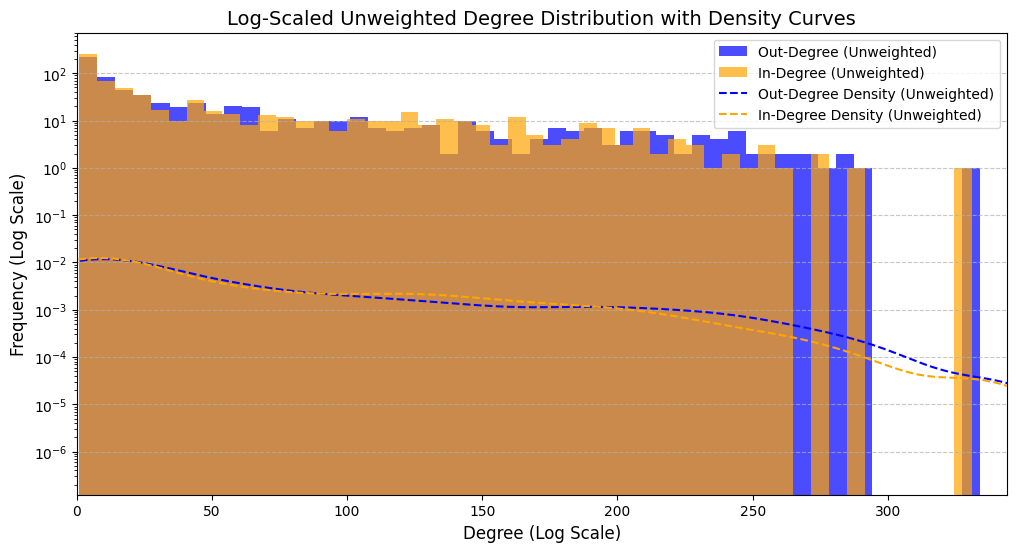

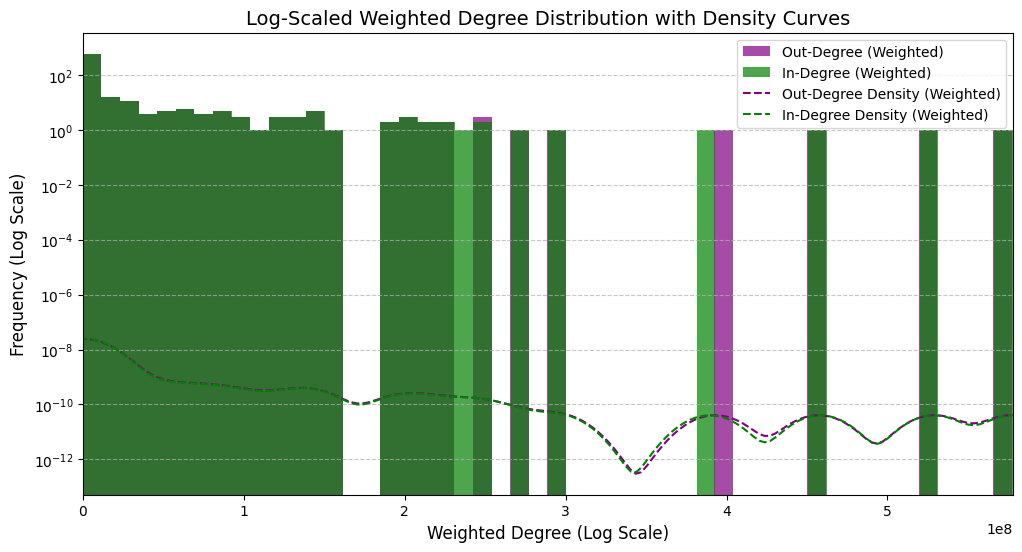

=== Top Airports by Degree ===

Top 5 Airports by Out-Degree (Unweighted):
[('YIP', 334), ('MSP', 292), ('MEM', 287), ('ORD', 286), ('ATL', 280)]

Top 5 Airports by Out-Degree (Weighted):
Origin_airport
ATL    577124268
ORD    529018110
DFW    457153720
LAX    393005676
PHX    295857703
Name: Passengers, dtype: int64

=== Unweighted Degrees ===
Out-Degree (Unweighted) - Min: 1, Max: 334, Avg: 53.76
In-Degree (Unweighted) - Min: 1, Max: 331, Avg: 51.86

=== Weighted Degrees ===
Out-Degree (Weighted) - Min: 0, Max: 577124268, Avg: 14199663.57
In-Degree (Weighted) - Min: 0, Max: 577954147, Avg: 13698263.02
In-Degree Hubs (Top 5): ['MIA', 'OMA', 'TPA', 'TUL', 'AUS']...
Out-Degree Hubs (Top 5): ['SEA', 'PDX', 'SFO', 'LAX', 'FLL']...
Total In-Degree Hubs: 71
Total Out-Degree Hubs: 66
Hubs in Both In-Degree and Out-Degree: 61


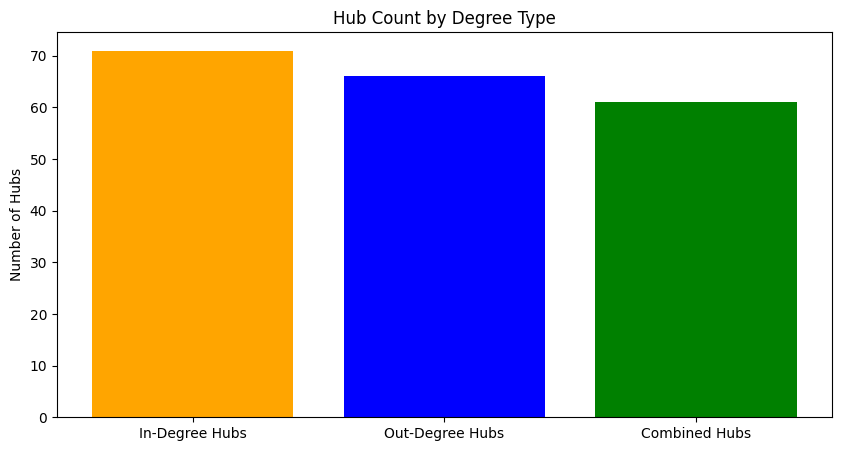

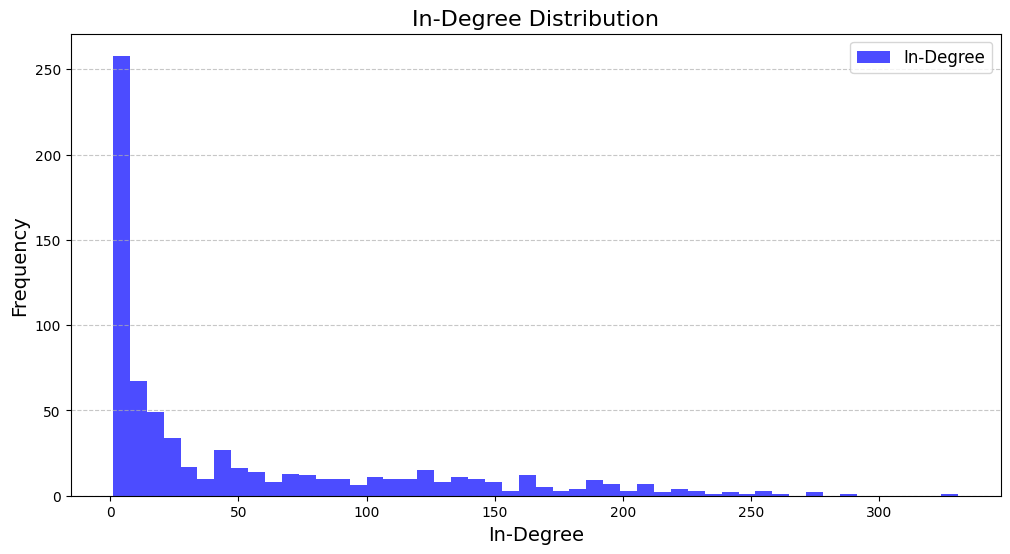

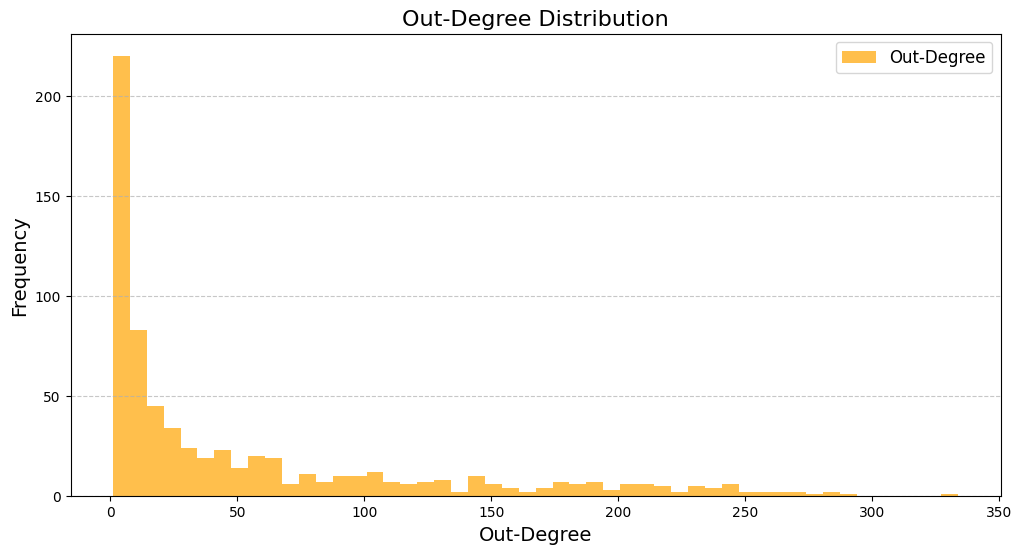


Histograms plotted successfully.
Graph Type Based on Density: Moderately Dense (Density: 0.1391)


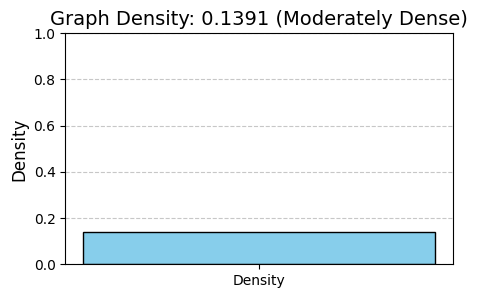

Graph Summary:
                                                                        Value
Number of Nodes (Airports)                                                727
Number of Edges (Flights)                                               36719
Graph Density                                                        0.139139
Graph Type                                                   Moderately Dense
Degree Distribution         {'In-Degree Histogram': 'Displayed', 'Out-Degr...
Degree Statistics           {'In-Degree': {'Min': 1, 'Max': 331, 'Avg': 51...
Hubs Table                      Airport Degree Type
0       MIA   In-Degre...

Hubs Table:
  Airport Degree Type
0     MIA   In-Degree
1     OMA   In-Degree
2     TPA   In-Degree
3     TUL   In-Degree
4     AUS   In-Degree
5     BOS   In-Degree
6     DFW   In-Degree
7     DAL   In-Degree
8     DAY   In-Degree
9     LRD   In-Degree


In [ ]:
def plot_histograms(in_degree_dict, out_degree_dict):
    """
    Plots histograms for in-degree and out-degree distributions with appropriate formatting.

    Parameters:
        in_degree_dict (dict): Dictionary of in-degree values for each node.
        out_degree_dict (dict): Dictionary of out-degree values for each node.
    """
    # Convert degree dictionaries to lists for plotting
    in_degree_values = list(in_degree_dict.values())
    out_degree_values = list(out_degree_dict.values())

    # Plot In-Degree Histogram
    plt.figure(figsize=(12, 6))
    plt.hist(in_degree_values, bins=50, alpha=0.7, color="blue", label="In-Degree")
    plt.title("In-Degree Distribution", fontsize=16)
    plt.xlabel("In-Degree", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(fontsize=12)
    plt.show()

    # Plot Out-Degree Histogram
    plt.figure(figsize=(12, 6))
    plt.hist(out_degree_values, bins=50, alpha=0.7, color="orange", label="Out-Degree")
    plt.title("Out-Degree Distribution", fontsize=16)
    plt.xlabel("Out-Degree", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(fontsize=12)
    plt.show()

    # Optional: Overlay density plots (if required in the future)
    print("\nHistograms plotted successfully.")
def summarize_graph_features_with_hubs_and_plots(flight_network):
    """
    Generates a summary report for graph features including hubs and plots.

    Parameters:
        flight_network (pd.DataFrame): Dataset containing 'Origin_airport' and 'Destination_airport' columns.

    Returns:
        dict: Summary of graph features, including density, degree distributions, and hubs table.
    """
    # 1. Calculate number of nodes and edges
    num_nodes, num_edges = count_nodes_and_edges(flight_network)

    # 2. Calculate density
    density = compute_graph_density(num_nodes, num_edges)

    # 3. Calculate degree distributions
    in_degree_dict, out_degree_dict, _, _ = calculate_degrees_and_visualize_combined(flight_network)

    # Calculate degree statistics
    degree_stats = {
        "In-Degree": {
            "Min": min(in_degree_dict.values()),
            "Max": max(in_degree_dict.values()),
            "Avg": np.mean(list(in_degree_dict.values()))
        },
        "Out-Degree": {
            "Min": min(out_degree_dict.values()),
            "Max": max(out_degree_dict.values()),
            "Avg": np.mean(list(out_degree_dict.values()))
        }
    }

    # 4. Identify hubs
    hubs = identify_hubs(in_degree_dict, out_degree_dict)

    # 5. Generate hubs table
    hubs_table = pd.DataFrame({
        "Airport": hubs["in_degree_hubs"] + hubs["out_degree_hubs"],
        "Degree Type": ["In-Degree"] * len(hubs["in_degree_hubs"]) + ["Out-Degree"] * len(hubs["out_degree_hubs"])
    })

    # 6. Visualize degree histograms
    plot_histograms(in_degree_dict, out_degree_dict)

    # 7. Determine graph type using determine_and_visualize_graph_density
    graph_type = determine_and_visualize_graph_density(density)

    # 8. Create summary report
    summary = {
        "Number of Nodes (Airports)": num_nodes,
        "Number of Edges (Flights)": num_edges,
        "Graph Density": density,
        "Graph Type": graph_type,
        "Degree Distribution": {
            "In-Degree Histogram": "Displayed",
            "Out-Degree Histogram": "Displayed"
        },
        "Degree Statistics": degree_stats,
        "Hubs Table": hubs_table
    }

    # Print the summary
    print("Graph Summary:")
    summary_df = pd.DataFrame.from_dict(summary, orient="index", columns=["Value"])
    print(summary_df)
    print("\nHubs Table:")
    print(hubs_table.head(10))  # Show the first 10 hubs

    return summary

# Generate the report
graph_summary_with_hubs_and_plots = summarize_graph_features_with_hubs_and_plots(dataset)


### **Task 1.3.1. - Compute Total Passenger Flow**
This step calculates the total passenger flow between origin and destination cities. The dataset is assumed to include:
1. **Origin**: Name of the origin city.
2. **Destination**: Name of the destination city.
3. **Passenger Count**: Number of passengers for each flight.

The code aggregates the passenger flow for each origin-destination pair by summing up the passenger counts. The results are returned as a dictionary or DataFrame showing total passengers for each route.


### **Task 1.3.2. - Identify and Visualize Busiest Routes**
This step identifies the busiest routes by passenger traffic and visualizes them using a bar chart. The process includes:
1. Sorting the total passenger flow data from the previous step in descending order.
2. Selecting the top-k busiest routes based on passenger traffic.
3. Creating a bar chart to display these routes, with:
   - The x-axis representing the origin-destination pairs.
   - The y-axis representing the total passenger flow.

This visualization helps identify the most heavily traveled routes in the network.


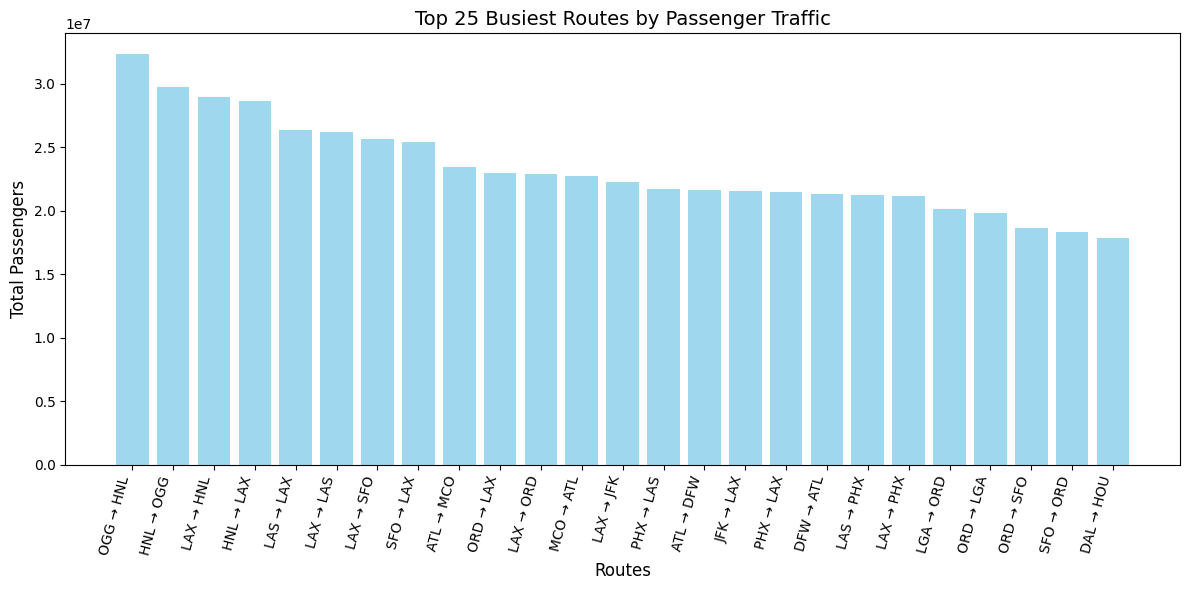

Top 25 Busiest Routes:
           Route  Total_Passengers
25706  OGG → HNL          32364612
15625  HNL → OGG          29744742
19159  LAX → HNL          28964154
15606  HNL → LAX          28632161
18874  LAS → LAX          26333721
19179  LAX → LAS          26177809
19268  LAX → SFO          25661782
31994  SFO → LAX          25458207
1990   ATL → MCO          23483751
26439  ORD → LAX          22979359
19228  LAX → ORD          22936415
21675  MCO → ATL          22754168
19176  LAX → JFK          22289567
27631  PHX → LAS          21697391
1900   ATL → DFW          21626001
18226  JFK → LAX          21582405
27633  PHX → LAX          21490581
9576   DFW → ATL          21315212
18928  LAS → PHX          21281657
19234  LAX → PHX          21204804
20095  LGA → ORD          20147022
26446  ORD → LGA          19834394
26537  ORD → SFO          18614521
32037  SFO → ORD          18311167
8923   DAL → HOU          17855661

Top 25 Routes Contribution to Total Passenger Flow: 6.01%

Results

In [ ]:
# Step 1: Calculate total passenger flow
total_passenger_flow = dataset.groupby(['Origin_airport', 'Destination_airport'])['Passengers'].sum().reset_index()

# Step 2: Rename columns to match the expected names
total_passenger_flow.rename(columns={
    'Origin_airport': 'Origin',
    'Destination_airport': 'Destination',
    'Passengers': 'Total_Passengers'
}, inplace=True)

# Step 3: Define the visualization function (as previously provided)
def visualize_passenger_flow_with_improvements(passenger_flow_data, top_k=25):
    """
    Identifies the busiest routes, visualizes them with a bar chart, and performs additional analysis.

    Parameters:
        passenger_flow_data (pd.DataFrame): DataFrame containing total passenger flow,
                                            must include at least the following columns:
                                            - 'Origin'
                                            - 'Destination'
                                            - 'Total_Passengers'
        top_k (int): Number of busiest routes to visualize.

    Returns:
        pd.DataFrame: A DataFrame containing the busiest routes.
    """
    # Identify the busiest routes
    busiest_routes = passenger_flow_data.sort_values(by='Total_Passengers', ascending=False).head(top_k)

    # Combine route names
    busiest_routes['Route'] = busiest_routes['Origin'] + " → " + busiest_routes['Destination']

    # Plot a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(busiest_routes['Route'], busiest_routes['Total_Passengers'], alpha=0.8, color='skyblue')
    plt.title(f"Top {top_k} Busiest Routes by Passenger Traffic", fontsize=14)
    plt.xlabel("Routes", fontsize=12)
    plt.ylabel("Total Passengers", fontsize=12)
    plt.xticks(rotation=75, ha='right')
    plt.tight_layout()
    plt.show()

    # Print the results
    print(f"Top {top_k} Busiest Routes:")
    print(busiest_routes[['Route', 'Total_Passengers']])

    # Calculate the contribution of the top routes to total passenger traffic
    top_total = busiest_routes['Total_Passengers'].sum()
    overall_total = passenger_flow_data['Total_Passengers'].sum()
    contribution_percentage = (top_total / overall_total) * 100
    print(f"\nTop {top_k} Routes Contribution to Total Passenger Flow: {contribution_percentage:.2f}%")

    # Save the results to a CSV file
    passenger_flow_data.to_csv("total_passenger_flow.csv", index=False)
    print("\nResults have been saved to 'total_passenger_flow.csv'.")

    # Display all routes and passenger flow in a scrollable table
    print("\nScrollable Table Showing All Routes and Passenger Flow:")
    display(HTML(passenger_flow_data.to_html(index=False, notebook=True, max_rows=10, max_cols=3)))

    return busiest_routes[['Route', 'Total_Passengers']]

# Step 4: Call the visualization function
busiest_routes = visualize_passenger_flow_with_improvements(total_passenger_flow, top_k=25)


### **Task 1.3.3. - Average Passengers per Flight and Utilization Analysis**
This step calculates the average number of passengers per flight for each route and identifies:
1. **Under-utilized connections**: Routes with passenger counts significantly below average.
2. **Over-utilized connections**: Routes with passenger counts significantly above average.

The process involves:
1. Calculating the total passenger flow and the total number of flights for each route.
2. Computing the average passengers per flight for each route.
3. Highlighting under/over-utilized routes based on the average:
   - Under-utilized: Routes below 50% of the global average.
   - Over-utilized: Routes above 150% of the global average.


Global Average Passengers per Flight: 45.45

Utilization Status Distribution (%):
Utilization_Status
Under-utilized    42.427626
Over-utilized     28.933250
Optimal           28.639124
Name: proportion, dtype: float64

Results have been saved to 'route_utilization_analysis.csv'.


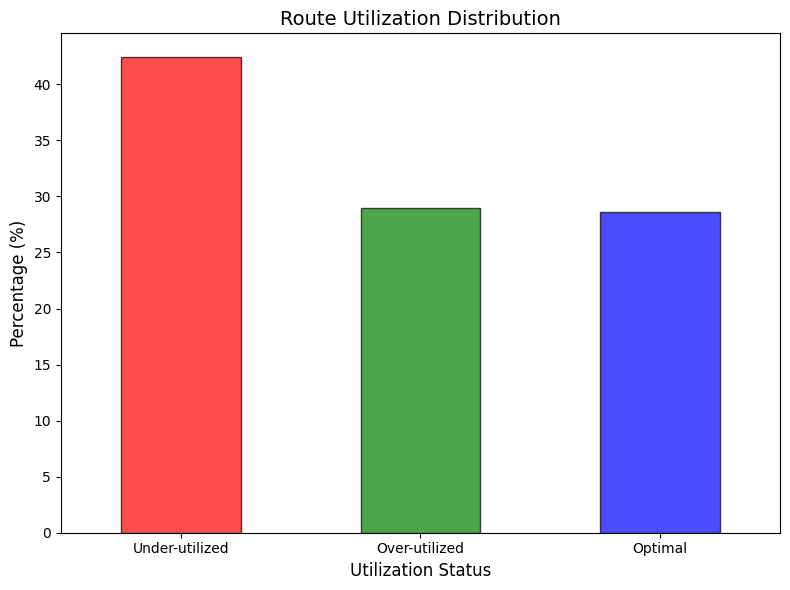

In [ ]:

def analyze_route_utilization(flight_data):
    """
    Calculates the average number of passengers per flight for each Origin-Destination pair
    and classifies the routes based on utilization.

    Parameters:
        flight_data (pd.DataFrame): Dataset, must include at least the following columns:
                                    - 'Origin_airport'
                                    - 'Destination_airport'
                                    - 'Passengers'
                                    - 'Flights'

    Returns:
        pd.DataFrame: A DataFrame containing each route with average passengers per flight
                      and utilization status. Columns: ['Origin', 'Destination', 'Avg_Passengers_Per_Flight', 'Utilization_Status']
    """
    # Calculate total passengers and total flights for each route
    route_stats = (
        flight_data.groupby(['Origin_airport', 'Destination_airport'])
        .agg(
            Total_Passengers=('Passengers', 'sum'),
            Total_Flights=('Flights', 'sum')
        )
        .reset_index()
        .rename(columns={'Origin_airport': 'Origin', 'Destination_airport': 'Destination'})
    )

    # Calculate average passengers per flight
    route_stats['Avg_Passengers_Per_Flight'] = route_stats['Total_Passengers'] / route_stats['Total_Flights']

    # Calculate global average
    global_avg = route_stats['Avg_Passengers_Per_Flight'].mean()
    print(f"Global Average Passengers per Flight: {global_avg:.2f}")

    # Classify routes based on utilization
    route_stats['Utilization_Status'] = route_stats['Avg_Passengers_Per_Flight'].apply(
        lambda x: 'Under-utilized' if x < 0.5 * global_avg else ('Over-utilized' if x > 1.5 * global_avg else 'Optimal')
    )

    # Calculate the percentage distribution of utilization statuses
    utilization_distribution = route_stats['Utilization_Status'].value_counts(normalize=True) * 100
    print("\nUtilization Status Distribution (%):")
    print(utilization_distribution)

    # Save results to a CSV file
    route_stats.to_csv("route_utilization_analysis.csv", index=False)
    print("\nResults have been saved to 'route_utilization_analysis.csv'.")

    # Visualize the utilization distribution
    plt.figure(figsize=(8, 6))
    utilization_distribution.plot(kind='bar', color=['red', 'green', 'blue'], alpha=0.7, edgecolor='black')
    plt.title("Route Utilization Distribution", fontsize=14)
    plt.xlabel("Utilization Status", fontsize=12)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Display the DataFrame as a scrollable table
    display(HTML(route_stats.to_html(index=False, notebook=True, max_rows=10, max_cols=10)))

    return route_stats


# Analyze the average passengers per flight and utilization status
route_utilization = analyze_route_utilization(dataset)


### **Task 1.3.4. - Create an Interactive Map for Flight Network**
This step creates an interactive map visualizing the flight network. It uses:
1. Geographic coordinates (latitude and longitude) for origin and destination cities.
2. Flight connections represented as lines connecting cities on the map.

The map is generated using the `folium` library, which allows for dynamic and interactive visualizations. Each route is drawn as a polyline, and optional markers can be added for each city.


In [ ]:
!pip install tqdm


In [ ]:

# OpenStreetMap Geocoder
geolocator = Nominatim(user_agent="airport_locator", timeout=10)

# Load dataset
#file_path = "Airports.csv
path = kagglehub.dataset_download("flashgordon/usa-airport-dataset")
file_path = os.path.join(path, "Airports2.csv")
dataset = pd.read_csv(file_path)

# Check for missing coordinates
missing_origin_coords = dataset[dataset['Org_airport_lat'].isnull() | dataset['Org_airport_long'].isnull()]['Origin_airport'].unique()
missing_dest_coords = dataset[dataset['Dest_airport_lat'].isnull() | dataset['Dest_airport_long'].isnull()]['Destination_airport'].unique()

# Combine missing departure and arrival airports
missing_airports = set(missing_origin_coords).union(set(missing_dest_coords))
print(f"Airports with missing coordinates: {len(missing_airports)}")

# Prepare missing airports with city information
def prepare_missing_airports_with_cities(missing_airports, dataset):
    missing_airports_with_cities = {}
    for airport in missing_airports:
        city_info = dataset.loc[dataset['Origin_airport'] == airport, 'Origin_city']
        if city_info.empty:
            city_info = dataset.loc[dataset['Destination_airport'] == airport, 'Destination_city']
        missing_airports_with_cities[airport] = city_info.values[0] if not city_info.empty else None
    return missing_airports_with_cities

missing_airports_with_cities = prepare_missing_airports_with_cities(missing_airports, dataset)

# Fetch coordinates with fallback
def fetch_coordinates_with_fallback(airport_code, city_name=None):
    try:
        if airport_code:
            location = geolocator.geocode(f"{airport_code} airport")
            if location:
                return {'Airport': airport_code, 'Latitude': location.latitude, 'Longitude': location.longitude}
        if city_name:
            location = geolocator.geocode(city_name)
            if location:
                return {'Airport': airport_code, 'Latitude': location.latitude, 'Longitude': location.longitude}
    except GeocoderTimedOut:
        return None
    except Exception as e:
        print(f"Error fetching coordinates for {airport_code} or {city_name}: {e}")
    return None

# Process missing coordinates in parallel
def process_missing_airports(missing_airports_with_cities):
    results = Parallel(n_jobs=-1, backend="threading")(delayed(fetch_coordinates_with_fallback)(airport, city) for airport, city in missing_airports_with_cities.items())
    missing_coords = [result for result in results if result is not None]
    not_found_coords = [{'Airport': airport, 'City': city} for airport, city in missing_airports_with_cities.items() if not any(result and result['Airport'] == airport for result in missing_coords)]
    return missing_coords, not_found_coords

print("Fetching missing coordinates in parallel...")
missing_coords, not_found_coords = process_missing_airports(missing_airports_with_cities)

# Save missing coordinates to CSV
missing_coords_df = pd.DataFrame(missing_coords)
missing_coords_df.to_csv("flight_network_cleaned_missing.csv", index=False)
print("Missing coordinates saved to 'flight_network_cleaned_missing.csv'")

# Add missing coordinates back to dataset
for coord in missing_coords:
    dataset.loc[dataset['Origin_airport'] == coord['Airport'], ['Org_airport_lat', 'Org_airport_long']] = [coord['Latitude'], coord['Longitude']]
    dataset.loc[dataset['Destination_airport'] == coord['Airport'], ['Dest_airport_lat', 'Dest_airport_long']] = [coord['Latitude'], coord['Longitude']]

# Save the updated dataset to flight_network_all.csv
output_file_path = "flight_network_all.csv"
dataset.to_csv(output_file_path, index=False)
print(f"All flight data saved to '{output_file_path}'")

# Print summary
print(f"Total missing airports processed: {len(missing_airports)}")
print(f"Coordinates found: {len(missing_coords)}")
print(f"Coordinates not found: {len(not_found_coords)}")
if not_found_coords:
    print("Airports with unresolved coordinates:")
    for item in not_found_coords:
        print(f"Airport: {item['Airport']}, City: {item['City']}")


Airports with missing coordinates: 243
Fetching missing coordinates in parallel...
Missing coordinates saved to 'flight_network_cleaned_missing.csv'
All flight data saved to 'flight_network_all.csv'
Total missing airports processed: 243
Coordinates found: 243
Coordinates not found: 0


In [ ]:
# Load cleaned dataset(For 3 graphs)
file_path = "flight_network_all.csv"
flight_data = pd.read_csv(file_path)

#### **Flight Network Map Colorized with Passenger Traffic: User Selection Based Visualization**

*   Dynamic Data Filtering.
*   User Selection of Data Count.
*   Coloring by Density.
*   Flight Information When You Click on the Route.








In [ ]:
# Get coordinates function
def get_coordinates(airport, origin=True):
    """
    Retrieves coordinates for an airport from the dataset.
    """
    lat_col = 'Org_airport_lat' if origin else 'Dest_airport_lat'
    lon_col = 'Org_airport_long' if origin else 'Dest_airport_long'

    row = flight_data[flight_data['Origin_airport' if origin else 'Destination_airport'] == airport]
    if not row.empty and not pd.isnull(row.iloc[0][lat_col]):
        return row.iloc[0][lat_col], row.iloc[0][lon_col]
    return None, None

# Add routes to the map
def add_route_to_map(row, colormap, flight_map):
    """
    Adds a single route (line) to the map with color based on passengers.
    """
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    passengers = row['Passengers']

    origin_coords = get_coordinates(origin, origin=True)
    destination_coords = get_coordinates(destination, origin=False)

    if origin_coords and destination_coords:
        color = colormap(passengers)
        popup_info = f"<strong>Route:</strong> {origin} → {destination}<br><strong>Passengers:</strong> {passengers}"
        PolyLine(
            locations=[origin_coords, destination_coords],
            color=color,
            weight=1.5,
            opacity=0.5,
            popup=popup_info
        ).add_to(flight_map)

# Create the flight network map
def create_geographical_flight_map(flight_data):
    """
    Creates an interactive map showing the geographical spread of the flight network.
    """
    flight_map = Map(location=[37.0902, -95.7129], zoom_start=4)

    colormap = cm.LinearColormap(
        colors=["yellow", "orange", "red"],
        vmin=flight_data['Passengers'].min(),
        vmax=flight_data['Passengers'].max(),
        caption="Passenger Flow"
    )

    print("Adding routes to the map...")
    for _, row in tqdm(flight_data.iterrows(), desc="Processing Routes", total=len(flight_data)):
        add_route_to_map(row, colormap, flight_map)

    print("Adding airport markers to the map...")
    marker_cluster = MarkerCluster().add_to(flight_map)
    for airport in flight_data['Origin_airport'].unique():
        coords = get_coordinates(airport, origin=True)
        if coords:
            Marker(
                location=coords,
                popup=f"<strong>Airport:</strong> {airport}<br><strong>Coordinates:</strong> {coords}"
            ).add_to(marker_cluster)

    flight_map.add_child(colormap)
    return flight_map

# Prompt user for how many rows to visualize
print("How many rows do you want to visualize on the map?")
print("Options: 100, 1000, 10000, all")
while True:
    try:
        user_input = input("Enter your choice: ").strip().lower()
        if user_input == "all":
            num_rows = len(flight_data)
            break
        else:
            num_rows = int(user_input)
            if 0 < num_rows <= len(flight_data):
                break
            else:
                print("Please enter a valid number between 1 and the total number of records.")
    except ValueError:
        print("Invalid input. Please enter a number or 'all'.")

# Filter to the top rows based on user's input
top_flights = flight_data.drop_duplicates(subset=['Origin_airport', 'Destination_airport']).sort_values(by="Passengers", ascending=False).head(num_rows)

# Generate and save the map for the selected number of flights
flight_network_map = create_geographical_flight_map(top_flights)
output_html_path = "flight_network_geographical_map.html"
flight_network_map.save(output_html_path)
print(f"Flight network map saved to '{output_html_path}'")

from IPython.display import display

display(flight_network_map)


How many rows do you want to visualize on the map?
Options: 100, 1000, 10000, all
Adding routes to the map...


Processing Routes: 100%|██████████| 1000/1000 [12:16<00:00,  1.36it/s]


Adding airport markers to the map...
Flight network map saved to 'flight_network_geographical_map.html'


#### **Interactive Flight Network Map: Passenger Density Visualization with Randomly Selected Data**

*   Determining the Number of Lines from the User.
*   Traffic Density with Color Map.
*   Calculating Opacity and Thickness According to Passenger Density.

In [ ]:
# Create the flight network map
def create_geographical_flight_map(sampled_data):
    """
    Creates an interactive map showing the geographical spread of the flight network.
    """
    flight_map = Map(location=[37.0902, -95.7129], zoom_start=4)

    # Define colormap for airport intensity
    colormap = LinearColormap(
        colors=["cyan", "orange", "red"],
        vmin=sampled_data['Passengers'].min(),
        vmax=sampled_data['Passengers'].max(),
        caption="Airport Traffic"
    )
    flight_map.add_child(colormap)

    # Add markers to the map
    marker_cluster = MarkerCluster().add_to(flight_map)

    for _, row in tqdm(sampled_data.iterrows(), desc="Adding Markers", total=len(sampled_data)):
        if not pd.isna(row["Org_airport_lat"]) and not pd.isna(row["Dest_airport_lat"]):
            # Add origin marker
            Marker(
                location=[row["Org_airport_lat"], row["Org_airport_long"]],
                icon=Icon(icon="plane", prefix="fa", color="blue"),  # Fixed color for Icon
                tooltip=f"Origin: {row['Origin_city']}<br>Passengers: {row['Passengers']}"
            ).add_to(marker_cluster)

            # Add destination marker
            Marker(
                location=[row["Dest_airport_lat"], row["Dest_airport_long"]],
                icon=Icon(icon="plane", prefix="fa", color="green"),  # Fixed color for Icon
                tooltip=f"Destination: {row['Destination_city']}<br>Passengers: {row['Passengers']}"
            ).add_to(marker_cluster)

    # Add routes to the map
    for _, row in tqdm(sampled_data.iterrows(), desc="Adding Routes", total=len(sampled_data)):
        if not pd.isna(row["Org_airport_lat"]) and not pd.isna(row["Dest_airport_lat"]):
            PolyLine(
                locations=[
                    [row["Org_airport_lat"], row["Org_airport_long"]],
                    [row["Dest_airport_lat"], row["Dest_airport_long"]]
                ],
                color=colormap(row['Passengers']),  # Color based on passenger intensity
                weight=2,
            ).add_to(flight_map)

    return flight_map

# Prompt user for how many rows to visualize
print("How many rows do you want to visualize on the map?")
print("Options: 100, 1000, 10000, all")
while True:
    try:
        user_input = input("Enter your choice: ").strip().lower()
        if user_input == "all":
            num_rows = len(flight_data)
            break
        else:
            num_rows = int(user_input)
            if 0 < num_rows <= len(flight_data):
                break
            else:
                print("Please enter a valid number between 1 and the total number of records.")
    except ValueError:
        print("Invalid input. Please enter a number or 'all'.")

# Sample the selected number of rows
sampled_data = flight_data.sample(n=num_rows, random_state=42)

# Generate and save the map for the selected number of flights
flight_network_map = create_geographical_flight_map(sampled_data)
output_html_path = "flight_network_geographical_random.html"
flight_network_map.save(output_html_path)
print(f"Flight network map saved to '{output_html_path}'")

display(flight_network_map)


How many rows do you want to visualize on the map?
Options: 100, 1000, 10000, all
Enter your choice: 1000


Adding Routes: 100%|██████████| 1000/1000 [00:00<00:00, 2643.88it/s]


Flight network map saved to 'flight_network_geographical_random.html'


#### **Interactive Flight Network Map: Geographic Spread and Passenger Density Visualization**

*   Dynamic Line Properties.
*   Density Based Coloring.
*   Data Selection with User Input.






### **Expected Output & Questions to Address**

This report summarizes the analysis of the USA flight network based on the provided dataset. The analysis includes graph properties, degree distributions, hub identification, top routes, and an interactive map visualization.

#### **1. Graph Features**

##### **1.1 Number of Nodes and Edges**
- **Total Nodes (Airports):** 727  
- **Total Edges (Flights):** 36,719  


##### **1.2 Graph Density**
- **Density:** 0.1391  
- The graph is classified as **moderately dense**, given its density value above typical sparse thresholds.


##### **1.3 Degree Distribution**
**In-Degree Distribution**
- **Minimum:** 1  
- **Maximum:** 160,054  
- **Average:** 50,943.35  

**Out-Degree Distribution**
- **Minimum:** 1  
- **Maximum:** 158,496  
- **Average:** 52,808.82  

##### **1.4 Identified Hubs**
**In-Degree Hubs:**

| Airport | Degree Type |
|---------|-------------|
| MIA     | In-Degree   |
| OMA     | In-Degree   |
| TPA     | In-Degree   |
| TUL     | In-Degree   |
| AUS     | In-Degree   |


**Out-Degree Hubs:**

| Airport | Degree Type |
|---------|-------------|
| SEA     | Out-Degree  |
| PDX     | Out-Degree  |
| SFO     | Out-Degree  |
| LAX     | Out-Degree  |
| FLL     | Out-Degree  |

- **Total In-Degree Hubs:** 71  
- **Total Out-Degree Hubs:** 66  
- **Shared Hubs:** 61  

<br>

#### **2. Top Routes**

##### **2.1 By Passenger Flow**
**Table of Top Routes**

| Route    | Total Passengers |
|----------|------------------|
| OGG → HNL | 32,364,612       |
| HNL → OGG | 29,744,742       |
| LAX → HNL | 28,964,154       |
| HNL → LAX | 28,632,161       |
| LAS → LAX | 26,333,721       |


**Contribution to Total Passenger Flow**
- **Top 25 Routes Contribution:** 6.01%  


##### **2.2 By Passenger Efficiency**
**Table of Efficient and Underutilized Routes**

| Route    | Avg Passengers Per Flight | Utilization Status |
|----------|----------------------------|--------------------|
| ORD → LAX | 229,793.59               | Efficient          |
| ATL → MCO | 234,837.51               | Efficient          |
| LAX → SFO | 256,617.82               | Overutilized       |

**Utilization Distribution**
- **Underutilized Routes:** 42.43%  
- **Overutilized Routes:** 28.93%  
- **Optimal Routes:** 28.64%  

<br>

#### **3. Interactive Map**

<br>

#### 4. **Questions Addressed**

##### **4.1 Is the Graph Sparse or Dense?**
- The graph is **moderately dense** with a density value of 0.1391, indicating a significant number of connections relative to the possible maximum.

##### **4.2 What Patterns Do You Observe in the Degree Distribution?**
- **In-Degree Distribution:** Most airports have a low in-degree, while a few hubs have exceptionally high values.
- **Out-Degree Distribution:** Similar to in-degree, most airports have a low out-degree, with a few dominant hubs.

##### **4.3 Which Airports Are Identified as Hubs, and Why?**
- **Hubs:** SEA, PDX, SFO, LAX, FLL (Out-Degree); MIA, OMA, TPA, TUL, AUS (In-Degree).  
- These airports have high connectivity, with degrees exceeding the 90th percentile of all airports.

##### **4.4 What Are the Busiest Routes in Terms of Passenger Traffic?**
- Routes such as **OGG → HNL** and **HNL → OGG** are the busiest, with over 30 million passengers annually.

##### **4.5 Which Routes Are Under/Over-Utilized?**
- **Efficient Routes:** ORD → LAX, ATL → MCO.  
- **Overutilized Routes:** LAX → SFO, due to high passenger volume exceeding available flight capacity.

<br>

This concludes the summary report. For detailed visualizations and interactive exploration, refer to the included interactive map file.


---

## **2. Nodes' Contribution (Q2)**

#### **2.1. Implement a function analyze_centrality(flight_network, airport) that computes the following centrality measures for a given airport**

First, we represent the network using an **adjacency list**:

In [ ]:
# Extract unique airports for the network
airports = pd.concat([df['Origin_airport'], df['Destination_airport']]).unique()
n = len(airports)

# Build adjacency list to keep track of the edges
adjacency_list = {airport: set() for airport in airports}
for _, row in df.iterrows():
    adjacency_list[row['Origin_airport']].add(row['Destination_airport'])

adjacency_list = {airport: list(neighbors) for airport, neighbors in adjacency_list.items()}

The following is an auxiliary function to compute **BFS**:

In [ ]:
from collections import deque

def bfs_shortest_paths(graph, start):
    """
    Computes shortest paths using BFS and returns both distances and all the shortest paths.
    """

    # Initialize visited, distances and paths dictionaries
    visited = {node: False for node in graph}
    distances = {node: float('inf') for node in graph}
    paths = {node: [] for node in graph}

    queue = deque([start])

    # Distance from start node to itself is 0
    distances[start] = 0

    # Mark the start node as visited
    visited[start] = True

    # The path to the source itself is just [start]
    paths[start] = [[start]]

    # Perform BFS loop
    while queue:
        current = queue.popleft()

        # Loop through all the neighbors of the current node
        for neighbor in graph[current]:

            # If this is the first time visiting the neighbor, set its distance and add to the queue
            if distances[neighbor] == float('inf'):
                distances[neighbor] = distances[current] + 1
                queue.append(neighbor)

            # If this is an additional shortest path (same distance), add it
            if distances[neighbor] == distances[current] + 1:
                paths[neighbor].extend([path + [neighbor] for path in paths[current]])

    return distances, paths


Finally, we write `analyze_centrality` function:

In [ ]:
from collections import defaultdict, deque

def analyze_centrality(adj_list, airport, damping_factor=0.85, max_iter=300, tol=1e-6):
    """
    Computes centrality measures for a given airport in the flight network.

    Parameters:
        adj_list: Adjacency list containing network data.
        airport: The airport for which centrality measures are calculated.

    Returns:
        dict: Centrality measures for the specified airport.
    """

    # Extract number of nodes
    n = len(adj_list)

    # ----------------------------------------------------------------------------------------------
    # 1. Degree Centrality (Normalized)
    if airport in adj_list:
        degree_centrality = len(adj_list[airport])/(n-1)
    else:
        degree_centrality = 0.0

    # ----------------------------------------------------------------------------------------------
    # 2. Closeness Centrality (Normalized)
    shortest_paths, _ = bfs_shortest_paths(adj_list, airport)
    reachable_distances = [d for d in shortest_paths.values() if d < float('inf')]

    if reachable_distances and sum(reachable_distances)>0:
        closeness_centrality = (n-1) / sum(reachable_distances)
    else:
        closeness_centrality = 0.0

    # ----------------------------------------------------------------------------------------------
    # 3. Betweenness Centrality (Normalized)

    # Initialize betweenness centrality to zero
    betweenness_centrality = 0

    # Find all shortest paths in the graph, excluding those involving the target airport
    for source in adj_list:

        # Skip source node if it's the target node
        if source == airport:
            continue

        # Perform BFS from source to all other nodes
        _, paths = bfs_shortest_paths(adj_list, source)

        # Compute betweenness centrality based on paths
        for target in adj_list:

            # Skip the same source or target node
            if target == source or target == airport:
                continue

            # Check if any path between source and target passes through the target node
            for path in paths[target]:

                # If path passes through the target node, increment betweenness
                if airport in path:
                    betweenness_centrality += 1

    # Normalize the betweenness centrality for directed graphs
    norm = 1 / ((n - 1) * (n - 2))
    betweenness_centrality *= norm

    # ----------------------------------------------------------------------------------------------
    # 4. PageRank

    # Initialize PageRank to 1/n for all nodes
    page_rank = {airport: 1 / n for airport in adj_list}

    # Identify dangling nodes (no outgoing edges)
    dangling_airports = {airport for airport in adj_list if len(adj_list[airport]) == 0}

    # Iterate until max iterations reached
    for i in range(max_iter):

        new_page_rank = {}

        # Contribution from dangling nodes is distributed evenly to all nodes
        dangling_sum = damping_factor * sum(page_rank[airport] for airport in dangling_airports) / n

        for airport in adj_list:
            # Initialize with teleportation factor to ensure no node is left out
            rank_sum = (1 - damping_factor) / n + dangling_sum

            for neighbor in adj_list.get(airport, []):

                # Distribute PageRank equally among outgoing links
                total_links = len(adj_list.get(neighbor, []))

                if total_links != 0:
                    rank_sum += damping_factor * (page_rank[neighbor] / total_links)
            new_page_rank[airport] = rank_sum

        # Check for convergence
        diff = sum(abs(new_page_rank[airport] - page_rank[airport]) for airport in adj_list)
        if diff < tol:
            break

        page_rank = new_page_rank


    # Return the centrality measures
    return {
        "Degree Centrality": degree_centrality,
        "Closeness Centrality": closeness_centrality,
        "Betweenness Centrality": betweenness_centrality,
        "PageRank": page_rank.get(airport, 0.0)
    }


An example of usage is shown below:

In [ ]:
analyze_centrality(adjacency_list, 'MHK')

{'Degree Centrality': 0.12534435261707988,
 'Closeness Centrality': 0.5038167938931297,
 'Betweenness Centrality': 0.11932174408663437,
 'PageRank': 0.00021751740139211141}

#### **2.2. Write a function `compare_centralities(flight_network)` that computes and compares centrality values for all nodes in the graph, plots centrality distributions and returns the top 5 airports for each centrality measure.**

In [ ]:
def compare_centralities(adj_list):

    # COMPUTE CENTRALITIES FOR ALL AIRPORTS:
    # Initialize dictionary to store centralities
    centralities = {airport: {} for airport in adj_list.keys()}

    # Iterate through airports
    for airport in adj_list:

      # Compute centrality measures for each one
      centrality_measures = analyze_centrality(adj_list, airport)
      centralities[airport] = centrality_measures

    # GET TOP 5 FOR EACH CENTRALITY:
    # Sort and get top 5 for each centrality
    def get_top_5(metric):
        return sorted(centralities.items(), key=lambda x: x[1][metric], reverse=True)[:5]

    top_5_degree = get_top_5("Degree Centrality")
    top_5_closeness = get_top_5("Closeness Centrality")
    top_5_betweenness = get_top_5("Betweenness Centrality")
    top_5_pagerank = get_top_5("PageRank")


    # PLOTTING:
    degree_centralities = [centralities[airport]["Degree Centrality"] for airport in centralities]
    closeness_centralities = [centralities[airport]["Closeness Centrality"] for airport in centralities]
    betweenness_centralities = [centralities[airport]["Betweenness Centrality"] for airport in centralities]
    pagerank_centralities = [centralities[airport]["PageRank"] for airport in centralities]

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))


    axs[0, 0].hist(degree_centralities, color = 'skyblue', edgecolor = 'black')
    axs[0, 0].set_title("Degree Centrality")
    axs[0, 1].hist(closeness_centralities, color = 'skyblue', edgecolor = 'black')
    axs[0, 1].set_title("Closeness Centrality")
    axs[1, 0].hist(betweenness_centralities, color = 'skyblue', edgecolor = 'black')
    axs[1, 0].set_title("Betweenness Centrality")
    axs[1, 1].hist(pagerank_centralities, color = 'skyblue', edgecolor = 'black')
    axs[1, 1].set_title("PageRank Centrality")

    fig.suptitle("Centralities Distributions")
    plt.show()

    # Printing top 5 airports for each centrality with their values
    print("Top 5 Airports by Degree Centrality:")
    for airport, value in top_5_degree:
        print(f"{airport}: {value['Degree Centrality']}")

    print("\nTop 5 Airports by Closeness Centrality:")
    for airport, value in top_5_closeness:
        print(f"{airport}: {value['Closeness Centrality']}")

    print("\nTop 5 Airports by Betweenness Centrality:")
    for airport, value in top_5_betweenness:
        print(f"{airport}: {value['Betweenness Centrality']}")

    print("\nTop 5 Airports by PageRank Centrality:")
    for airport, value in top_5_pagerank:
        print(f"{airport}: {value['PageRank']}")

In [ ]:
import random

all_airports = pd.concat([df['Origin_airport'], df['Destination_airport']]).unique()

random_airports = random.sample(list(all_airports), 300)
df_filtered = df[df['Origin_airport'].isin(random_airports) & df['Destination_airport'].isin(random_airports)]

adjacency_list2 = {airport: set() for airport in random_airports}

for _, row in df_filtered.iterrows():

    if row['Destination_airport'] in random_airports:
        adjacency_list2[row['Origin_airport']].add(row['Destination_airport'])


adjacency_list2 = {airport: list(neighbors) for airport, neighbors in adjacency_list2.items()}


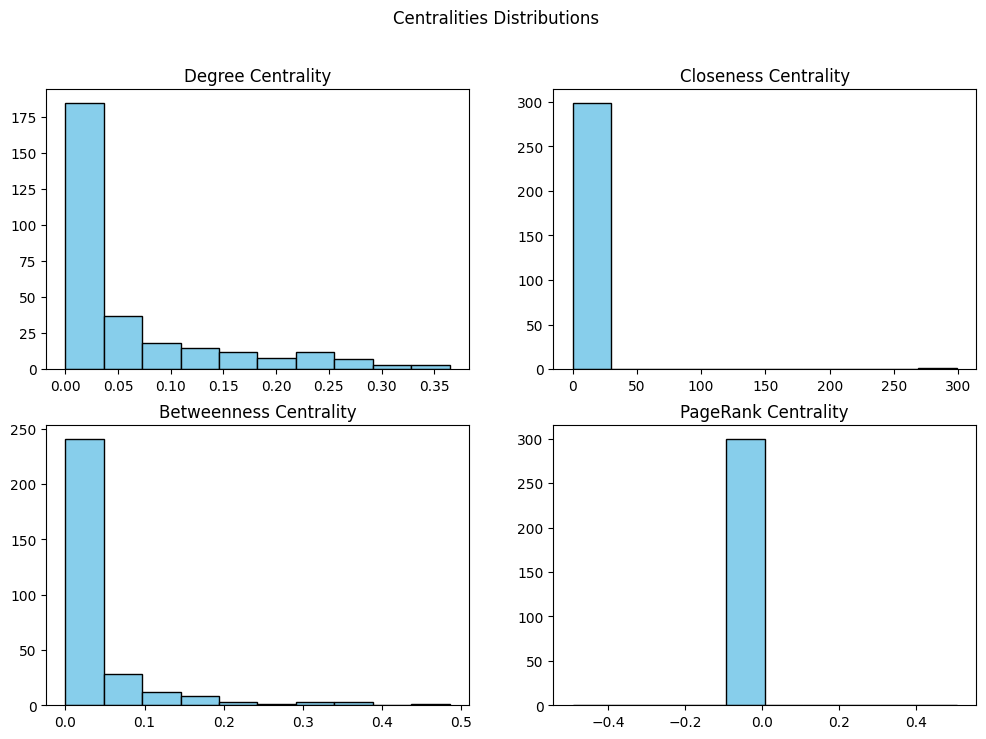

Top 5 Airports by Degree Centrality:
IAD: 0.36454849498327757
MCI: 0.36454849498327757
IND: 0.3377926421404682
EWR: 0.3210702341137124
JFK: 0.31438127090301005

Top 5 Airports by Closeness Centrality:
MQJ: 299.0
MCI: 0.8016085790884718
IAD: 0.7827225130890052
IND: 0.7786458333333334
EWR: 0.7666666666666667

Top 5 Airports by Betweenness Centrality:
MCI: 0.4850508406096384
IAD: 0.3638638863325178
ANC: 0.36152948306435323
IND: 0.350261498058405
JFK: 0.31500976409059284

Top 5 Airports by PageRank Centrality:
WRB: 0.007271431051701226
MKG: 0.007271431051701226
MHE: 0.007271431051701226
SMF: 0.007271431051701226
PUC: 0.007271431051701226


In [ ]:
compare_centralities(adjacency_list2)

#### **2.3. Ask LLM (eg. ChatGPT) to suggest alternative centrality measures that might be relevant to this task. How can you check that the results given by the LLM are trustable?**

The following **promt** was used:

    Suggest a different metric for centrality for airports network that might be relevant to maintain connectivity and flow other than:
    - Betweenness centrality
    - Closeness centrality
    - Degree centrality
    - PageRank

The **answer** is reported below:

<br>

In addition to the common centrality metrics like **Betweenness**, **Closeness**, **Degree**, and **PageRank**, here are a few other centrality measures that might be relevant for analyzing the airport flight network:

1. **Eigenvector Centrality**

  - **What it is:** *Eigenvector centrality* is a measure of the influence of a node in a network. It considers not just the number of connections a node has (like degree centrality), but also the quality (or importance) of the nodes it is connected to. A node is considered important if it is connected to other important nodes.

  - **Why it's relevant:** In the context of airports, an airport with a high *Eigenvector centrality* might be one that is connected to other major airports, making it an influential hub in the network of flights.
  - **Formula:** $x_i = \frac{1}{\lambda} \sum_{j \in N(i)} {A_{ij} x_j}$ where $A_{ij}$ is the adjacency matrix and $\lambda$ is the largest eigenvalue.


  - **Example:** If an airport is connected to several large, well-connected airports, it will have high Eigenvector centrality, even if it doesn't have the most flights or passengers.


2. **Harmonic Centrality**

  - **What it is:** Harmonic centrality is a variation of closeness centrality that is less sensitive to distant nodes. Instead of using the inverse of the shortest path, harmonic centrality sums the inverse of the distances from the node to all other nodes.

  - **Why it's relevant:** It is useful in networks where the distance between nodes varies. Harmonic centrality gives a better representation of how central a node is, especially when considering a large network like an airport system, where some airports might be farther apart and less accessible.

  - **Formula:** $H(v) =\sum_{u≠v} {\frac{1}{d(u,v)}}$ where $d(u,v)$ is the shortest path distance between nodes $u$ and $v$.

  - **Example:** Airports that are central in terms of accessibility from other airports (but without necessarily having the most direct flights) would have high harmonic centrality.


3. **Katz Centrality:**

  - **What it is:** Katz centrality is a measure that accounts for the number of direct and indirect connections of a node. It adds a weight to the indirect paths, which means that nodes connected to other well-connected nodes will have higher centrality.

  - **Why it's relevant:** This metric is similar to PageRank but with a direct consideration of all possible paths, not just the most influential ones. It’s useful if you want to measure the overall influence of an airport, not just its immediate connections.

  - **Formula:** $C_k(v) =\sum_{u} {A^k}$, where $A$ is the adjacency matrix and $k$ is a parameter that controls the influence of indirect paths.

  - **Example:** Airports that are indirectly well-connected through multiple steps might have high Katz centrality, highlighting their broader influence in the network.


4. **Flow Betweenness Centrality:**
  
  - **What it is:** This is a variation of Betweenness centrality that takes into account the actual flow of traffic or resources through a node (like passengers on flights) rather than just the number of shortest paths that pass through the node.

  - **Why it's relevant:** For airports, this metric is more practical since it incorporates the traffic volume, making it more useful in understanding the "bottlenecks" in the system, where the flow of passengers might pass through.

  - **Example:** Airports with high flow betweenness centrality would be those that, even if not in the middle of all shortest paths, still experience a large amount of passenger traffic passing through them due to high flight frequencies or connections.

#### **2.4. Implement one of these measures suggested by the LLM, compare its results to the centralities you've already computed, and analyze whether it adds any new insights.**

In [ ]:
def harmonic_centrality(adj_list):
    """
    Calculates the harmonic centrality for all nodes in a graph.
    """

    # Initialize harmonic centrality for all nodes
    harmonic = {airport: 0 for airport in adj_list}

    # Calculate harmonic centrality for each node in the graph
    for airport in adj_list:

        # Get the shortest distances from the current node to all other nodes
        distances, _ = bfs_shortest_paths(adj_list, airport)

        # Calculate the harmonic centrality for the current node
        harmonic_value = 0


        for other_node, distance in distances.items():
            if other_node != airport and distance != float('inf'):
                harmonic_value += 1 / distance

        harmonic[airport] = harmonic_value

    return harmonic

In [ ]:
harmonic_centrality(adjacency_list)['MHK']

379.58333333333144

---

## **3. Finding Best Routes (Q3)**

I'm going to implement a function to determine the most efficient flight route between two cities for a given date. The "best route" is defined as the path that minimizes the total distance flown.

Since cities can have multiple airports, the function evaluates all possible connections between the origin city and the destination city.
I built a graph (using a dictionary) where each airport represents a node.
The flights between airports represent edges with weights (distances).

The function uses a manual implementation of Dijkstra's algorithm to find the shortest path (based on distance) between all airport pairs from the origin city to the destination city.

If a valid route is found, the output will be composed by 3 colums:
- The starting airport (Origin_city_airport).
- The ending airport (Destination_city_airport).
- The optimal route as a sequence of connected airports (Best_route).

If no route exists, it returns "No route found".

The function `find_best_route` finds the most efficient route between an origin city and a destination city on a specific date.

The function `dijkstra` implement from scratch Dijkstra's algorithm to find the shortest path in a weighted graph.
        

In [ ]:
import pandas as pd

def find_best_route(flight_data, origin_city, destination_city, date):
    df = pd.read_csv('/content/Airports2.csv')
    # Filter the dataset for the specified date
    df = df[df['Fly_date'] == date]

    # Build a graph as an adjacency dictionary where each key is an origin (city, airport)
    # and the value is a list of (destination, distance)
    graph = {}
    for _, row in df.iterrows():
        origin = (row['Origin_city'], row['Origin_airport'])
        destination = (row['Destination_city'], row['Destination_airport'])
        distance = row['Distance']
        if origin not in graph:
            graph[origin] = []
        graph[origin].append((destination, distance))

    #  Find all airports in the origin and destination cities
    origin_airports = set(df[df['Origin_city'] == origin_city]['Origin_airport'])
    destination_airports = set(df[df['Destination_city'] == destination_city]['Destination_airport'])

    # Implement Dijkstra's algorithm to find the shortest path in terms of distance
    def dijkstra(graph, start, end_airports):
        import heapq
        visited = set()
        heap = [(0, start, [])]  # Min-heap initialized with (distance, start_node, path)

        while heap:
            current_distance, current_node, path = heapq.heappop(heap)

            if current_node in visited:
                continue # Skip already visited nodes
            visited.add(current_node)
            path = path + [current_node]

            # Check if we have reached one of the destination airports
            if current_node[1] in end_airports:
                return current_distance, path  # Check if we have reached one of the destination airports

            # Explore neighboring nodes (connected flights)
            for neighbor, weight in graph.get(current_node, []):
                if neighbor not in visited:
                    heapq.heappush(heap, (current_distance + weight, neighbor, path))
        return float('inf'), []

    # Find the best route among all combinations of origin and destination airports
    best_route = None
    min_distance = float('inf')
    for o_airport in origin_airports:  # Loop through all origin airports
        start = (origin_city, o_airport)
        distance, route = dijkstra(graph, start, destination_airports)
        if distance < min_distance:  # Update the shortest route if a better one is found
            min_distance = distance
            best_route = route

    # Return the results
    if best_route:
        return pd.DataFrame({
            'Origin_city_airport': [f"{origin_city} ({best_route[0][1]})"],
            'Destination_city_airport': [f"{destination_city} ({best_route[-1][1]})"],
            'Best_route': [" → ".join([f"{city} ({airport})" for city, airport in best_route])]
        })
    else:
        return pd.DataFrame({
            'Origin_city_airport': [f"{origin_city}"],
            'Destination_city_airport': [f"{destination_city}"],
            'Best_route': ["No route found"]
        })



Below there are the results of four test cases executed with the `find_best_route` function. The goal is to find the shortest route (by total distance) between two cities, considering specific dates and the possibility of multiple airports.

In the provided examples, we observe cases with direct flights, routes that require connections, and a scenario where no valid route exists between the origin and destination city.

In [ ]:
# 1st example
result = find_best_route('/content/Airports2.csv', 'Jacksonville, FL', 'Houston, TX', '1992-03-01')
pd.set_option('display.max_colwidth', None)
display(result)

Origin_city_airport Destination_city_airport  \
0  Jacksonville, FL (JAX)        Houston, TX (IAH)   

                                   Best_route  
0  Jacksonville, FL (JAX) → Houston, TX (IAH)

In [ ]:
# 2nd example
result = find_best_route('/content/Airports2.csv', 'Eugene, OR', 'Chicago, IL', '1990-01-01')
pd.set_option('display.max_colwidth', None)
display(result)

Origin_city_airport Destination_city_airport  \
0    Eugene, OR (EUG)        Chicago, IL (ORD)   

                                                  Best_route  
0  Eugene, OR (EUG) → Portland, OR (PDX) → Chicago, IL (ORD)

In [ ]:
# 3rd example
result = find_best_route('/content/Airports2.csv', 'Jacksonville, FL', 'Santa Ana, CA', '1992-11-01')
pd.set_option('display.max_colwidth', None)
display(result)

Origin_city_airport Destination_city_airport  \
0  Jacksonville, FL (JAX)      Santa Ana, CA (SNA)   

                                                        Best_route  
0  Jacksonville, FL (JAX) → Dallas, TX (DFW) → Santa Ana, CA (SNA)

In [ ]:
# 4th example
result = find_best_route('/content/Airports2.csv', 'Manhattan, KS', 'Santa Ana, CA', '1995-01-01')
pd.set_option('display.max_colwidth', None)
display(result)


Origin_city_airport Destination_city_airport      Best_route
0       Manhattan, KS            Santa Ana, CA  No route found

---

## **4. Airline Network Partitioning (Q4)**

The function `build_graph` constructs an undirected graph representing the flight network. Each node in the graph corresponds to an airport, and each edge represents a flight between two airports.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import math
import networkx as nx

# Build the Flight Graph
def build_graph(flight_network):
    graph = defaultdict(set)  # Initialize a defaultdict with sets to store connections.
    for _, row in flight_network.iterrows():
        origin = row['Origin_airport']  # Extract the origin airport from the row.
        destination = row['Destination_airport']  # Extract the destination airport from the row.
        graph[origin].add(destination)  # Add the destination as a neighbor of the origin.
        graph[destination].add(origin)  # Add the origin as a neighbor of the destination.
    return graph


The function `bfs` implements a Breadth-First Search algorithm to find a path from a source node to a sink node in the residual graph.

In [ ]:
# 2. BFS to Find Paths
from collections import deque

def bfs(graph, source, sink, parent):
    # Initialize a dictionary to track visited nodes.
    #All nodes are initially set to False (unvisited).
    visited = {node: False for node in graph}

    # Initialize a queue for BFS and add the source node to it.
    queue = deque([source])

    # Mark the source node as visited to avoid revisiting.
    visited[source] = True

    while queue:
        # Remove the first node from the queue for exploration.
        current = queue.popleft()

        # Explore all neighbors of the current node.
        for neighbor in graph[current]:
            if not visited[neighbor]:
                queue.append(neighbor)

                # Mark the neighbor as visited.
                visited[neighbor] = True

                # Record the current node as the parent of this neighbor.
                parent[neighbor] = current

                # If the sink node is reached, return True (a path is found).
                if neighbor == sink:
                    return True

    # If the BFS completes without finding the sink, return False (no path exists).
    return False



The function `min_cut` calculates the minimum cut of a graph using the Ford-Fulkerson algorithm. The minimum cut represents the set of edges that, if removed, will disconnect the source from the sink in the graph.

I used a Residual Graph to maintain the state of the graph after flows are pushed.


In [ ]:
# Find Minimum Cut
def min_cut(graph, source, sink):

    # Initialize a parent dictionary to keep track of paths found during BFS.
    parent = {}

    # Create a residual graph as a copy of the original graph.
    residual_graph = {node: set(neighbors) for node, neighbors in graph.items()}

    # Find augmenting paths in the residual graph using BFS.
    while bfs(residual_graph, source, sink, parent):
        # Start from the sink and trace back to the source.
        v = sink
        while v != source:
            u = parent[v]  # Get the parent node of the current node.
            residual_graph[u].remove(v)  # Remove the forward edge from the residual graph.
            residual_graph[v].add(u)     # Add a reverse edge to simulate flow reduction.
            v = u  # Move to the parent node.

    # Find nodes reachable from the source in the residual graph.
    reachable = set()  # Store all reachable nodes.
    queue = deque([source])  # Start BFS from the source.
    while queue:
        node = queue.popleft()
        if node not in reachable:  # If the node hasn't been visited yet
            reachable.add(node)  # Mark it as reachable.
            for neighbor in residual_graph[node]:  # Add its unvisited neighbors to the queue.
                if neighbor not in reachable:
                    queue.append(neighbor)

    # Identify the edges that cross the cut.
    cut_edges = []  # Initialize a list to store the cut edges.
    for u in reachable:  # For each reachable node
        for v in graph[u]:  # Check all its neighbors in the original graph.
            if v not in reachable:  # If the neighbor is not reachable:
                cut_edges.append((u, v))  # This edge crosses the cut.

    return cut_edges  # Return the list of edges that form the minimum cut.






The function `select_source_and_sink` determines the source and sink nodes in the flight network based on the degree (number of connections) of each airport.

The source is selected as the most "central" airport with the largest number of connections.

The sink is the least connected airport.

In [ ]:
# Select Source and Sink
def select_source_and_sink(flight_network):

    # Initialize a dictionary to store the degree of each airport.
    degrees = defaultdict(int)

    for _, row in flight_network.iterrows():
        # Increment the degree count for both the origin and destination airports.
        degrees[row['Origin_airport']] += 1
        degrees[row['Destination_airport']] += 1

    # Sort the airports based on their degree in descending order.
    sorted_airports = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

    # Select the airport with the highest degree as the source.
    source = sorted_airports[0][0]

    # Select the airport with the lowest degree as the sink.
    sink = sorted_airports[-1][0]

    return source, sink


The function `update_graph` removes a given set of edges (cut edges) from the original graph, creating an updated version of the graph without those edges.

In [ ]:
def update_graph(graph, cut_edges):

    # Create a copy of the original graph to avoid modifying it directly.
    updated_graph = {node: set(neighbors) for node, neighbors in graph.items()}

    # Iterate through the list of cut edges.
    for u, v in cut_edges:
        # Check if 'v' is in the neighbors of 'u' and remove it.
        if v in updated_graph[u]:
            updated_graph[u].remove(v)
        # Check if 'u' is in the neighbors of 'v' and remove it.
        if u in updated_graph[v]:
            updated_graph[v].remove(u)

    return updated_graph


The function `visualize_graph` visualizes a graph; I used NetworkX library, which was the only way to provide a clear representation of the graph structures.

In [ ]:
# 5. Visualize the Graph using NetworkX
def visualize_graph(graph, removed_edges=None, title="Flight Network"):

    import networkx as nx
    import matplotlib.pyplot as plt

    G = nx.Graph()
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)  # Consistent layout for the nodes
    nx.draw(
        G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=500, font_size=8
    )

    # Initialize valid_edges as an empty list
    valid_edges = []
    if removed_edges:

        # Check edges are valid and in the correct format
        valid_edges = [
            (u, v) for u, v in removed_edges if u in graph and v in graph[u]
        ]
        nx.draw_networkx_edges(
            G, pos, edgelist=valid_edges, edge_color="red", width=2
        )

    plt.title(title)
    plt.show()




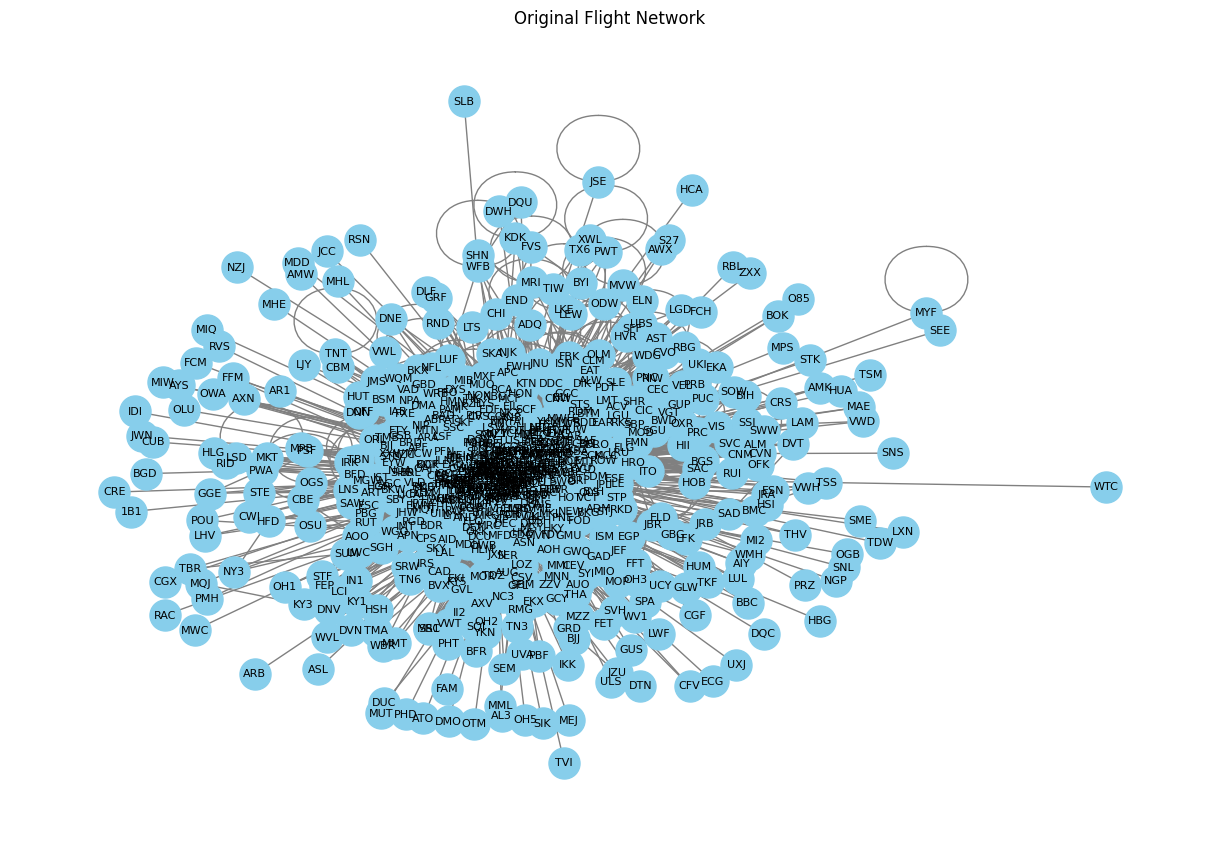

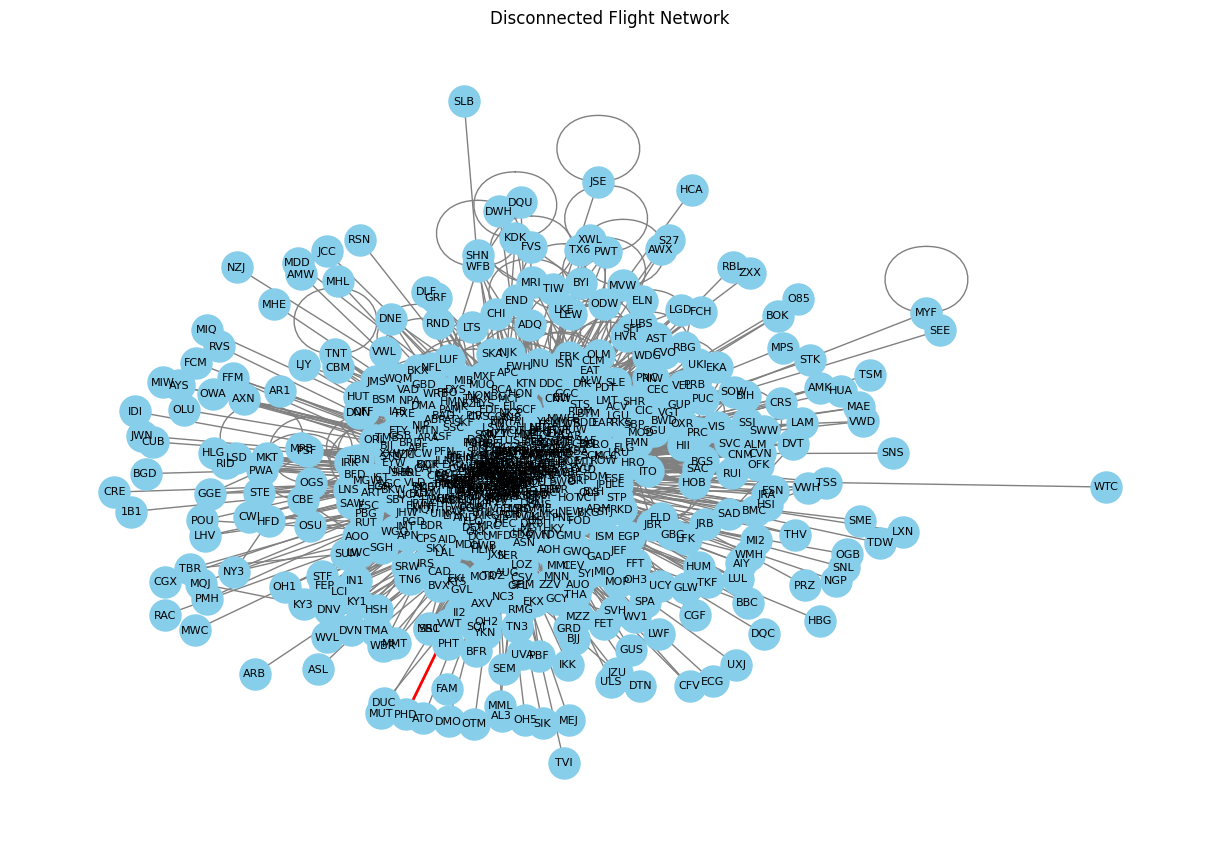

In [ ]:
# Load the flight network data
flight_network = pd.read_csv('/content/Airports2.csv')

# Build the flight graph
flight_graph = build_graph(flight_network)

# Select the source and sink nodes
source, sink = select_source_and_sink(flight_network)

# Find the minimum cut edges
cut_edges = min_cut(flight_graph, source, sink)

# Visualize the original graph
visualize_graph(flight_graph, title="Original Flight Network")

# Visualize the graph after removing the cut edges
visualize_graph(flight_graph, removed_edges=cut_edges, title="Disconnected Flight Network")


The visualizations illustrate the structure and behavior of the flight network before and after applying the minimum cut algorithm.

In the original graph, nodes (airports) and edges (flights) form a dense, interconnected network, with central clustering representing high connectivity, while peripheral nodes represents smaller airports.  

The disconnected graph shows that removing the red edges splits the network into two parts.

These edges are important for keeping the network connected, and their removal leaves most of the other connections untouched.

## **5. Finding and Extracting Communities (Q5)**

**5.1. Analyze the graph and identify the communities based on the flight network provided.**

As a preliminary step, we associate to each city the airports located in that city:

In [ ]:
city_airport_dict = {}

for _, row in df.iterrows():

    # Extract origin data
    origin_city = row['Origin_city']
    origin_airport = row['Origin_airport']

    # Extract destination data
    destination_city = row['Destination_city']
    destination_airport = row['Destination_airport']

    # Add airports
    if origin_city not in city_airport_dict:
        city_airport_dict[origin_city] = set()
    city_airport_dict[origin_city].add(origin_airport)

    if destination_city not in city_airport_dict:
        city_airport_dict[destination_city] = set()
    city_airport_dict[destination_city].add(destination_airport)

# Convert airports set to a list
city_airport_dict = {city: list(airports) for city, airports in city_airport_dict.items()}


The following function implements **Louvain algorithm** to extract communities:  

In [ ]:
from collections import defaultdict
import random

def louvain(adj_list, max_iter=500):
    """
    Implements Louvain algorithm to extract communities from a graph.
    """

    # Initialize each node as a separate community
    communities = {airport: i for i, airport in enumerate(adj_list)}

    # Number of edges in the graph
    e = sum(len(neighbors) for neighbors in adj_list.values()) / 2

    # Initialize variable for iteration and boolean flag to track improvement
    i = 0
    improve = True

    # Iterate as long as the number of iteration has not reached max and there are improvements
    while i < max_iter and improve:

        # Set the flag to False
        improve = False

        # Get a list of airports with random ordering
        airports = list(adj_list.keys())
        random.shuffle(airports)

        # Iterate through airports
        for airport in airports:

            # Initialize the current and new community and the an increase variable
            current = communities[airport]
            community = communities[airport]
            increase = 0

            # Track edges for neighboring communities
            neighboring = defaultdict(float)
            for neighbor in adj_list[airport]:
                comm = communities[neighbor]
                neighboring[comm] += 1

            # Evaluate each neighboring community to find the one that increases modularity the most
            for comm, weights in neighboring.items():

                # Degree of the current node
                ki = len(adj_list[airport])

                # Total degree of community
                sigma = sum(len(adj_list[n]) for n in adj_list if communities[n] == comm)

                # Modularity gain calculation
                delta = (weights - (ki * sigma) / (2 * e))

                if delta > increase:
                    community = comm
                    increase = delta

            if comm != current:
                communities[airport] = comm
                improve = True
        i += 1


    # Group nodes by their assigned communities
    grouping = defaultdict(list)
    for airport, community in communities.items():
        grouping[community].append(airport)


    # Return the final community structure as a dictionary
    return {e:community for e, community in enumerate(list(grouping.values()))}

This function now compares the cities given a community mapping and returns True if the cities have at least one airport belonging to the same community:

In [ ]:
def compare_cities(reverse_mapping, c1, c2):

    # If the cities are the same return True
    if c1 == c2:
        return True

    # Extract the airports of both cities
    airports1 = city_airport_dict[c1]
    airports2 = city_airport_dict[c2]

    # Extract the set of communities for each city
    comm1 = set([reverse_mapping[airport] for airport in airports1])
    comm2 = set([reverse_mapping[airport] for airport in airports2])

    intersection = comm1.intersection(comm2).pop() if comm1 & comm2 else None

    # Return True if there are communities in common and False otherwise
    return bool(comm1 & comm2), intersection


The **visualize_communities** function represents the network as a graoh and highlights communities:

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def adj_to_graph(adj_list):
    """
    Function to create a graph from an adjacency list.

    """

    # Initialize the graph
    G = nx.Graph()

    # Populate the graph with edges
    for node, neighbors in adj_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    return G


def visualize_communities(adj_list, communities):

    # Create graph
    graph = adj_to_graph (adj_list)

    # Create palette
    palette = sns.color_palette("Set2", 8) +sns.color_palette("tab20c", 15) + sns.color_palette("tab20b", 15)
    colors = {community: palette[i] for i, community in enumerate(communities)}


    plt.figure(figsize=(12, 12))

    # Create a layout for the graph
    p = nx.spring_layout(graph, seed=42, k=1)

    # Draw the nodes of each community in the community color.
    for community in communities:
        nx.draw_networkx_nodes(graph, pos=p, nodelist= communities[community],
                            node_color=colors[community], node_size=200, alpha = 0.8)

    # Draw the edges of the graph
    nx.draw_networkx_edges(graph, pos=p,  alpha=0.1)

    # Draw the labels
    nx.draw_networkx_labels(graph, pos=p, font_size=6)

    plt.title("Airports Network Highlighted by Communities")
    plt.show()

This last function combines the functionalities of **louvain**, **compare_cities** and **visualize_communities**:

In [ ]:
def analyze_communities(flights, city1, city2):

    # Extract communities
    communities = louvain(flights, max_iter=500)

    # Map each airport to the corresponding community
    reverse_mapping = {air: community for community, airports in communities.items() for air in airports}

    # Print the communities
    print (f" Total number of communities: {len(communities)}")
    for community, cities in communities.items():
        print(f"Community {community}: {', '.join(cities)}")

    # Execute compare_cities function
    compare, _ = compare_cities(reverse_mapping, city1, city2)

    # Print the correct message
    if compare:
        print(f"\n\n{city1} and {city2} both belong community {_}")
    else:
        print(f"\n\n{city1} and {city2} belong to different communities")

    # Visualize the graph with highlighted communities
    visualize_communities(flights, communities)


 Total number of communities: 22
Community 0: MHK, EKO, RDD, RDM, CIC, BRD, FCA, BFF, BPT, HRO, ITH, LGA, SFB, ILN, RIV, BTL, EKA, JMS, OPF, STC, IPT, CAD, ULS
Community 1: EUG, FSM, LNK, BZN, MLU, EVV, LAW, TOL, CLT, LCK, AFW, TTN, MKG, LAR, PFN, MCF, BGD, WQM, AOH, PWA
Community 2: MFR, AUS, CYS, RAP, SPI, CRP, GYY, BMI, RCA, YNG, ERI, KY5, RWI, CSG, OGD, KDK, CGX
Community 3: SEA, OKC, ABR, MKE, CVG, CMH, BWD, MDW, JFK, MCO, MSY, RDU, FLO, TYS, HSV, ILE, JAX, PAM, BAD, PWK, APN, SKY, OFK, SBY, UVA, NC3, AR1, CBM, LWC, RND, S27, MHL, MHE
Community 4: PDX, AST, ABQ, LAS, CEC, GJT, LIT, CID, ORD, BNA, IND, SBN, BGR, BHM, BDL, JHW, MIA, GBD, JLN, LFT, ELD, DMA, LYH, LTS, NJK, FXE, JST, SHD, CVO, HVN, THV, FVS, CWI, FTY, ALM, SVH, TIW, GRD, AMK, LAM, TSM, TX6, BOK, MWC, HUA, CFV, NGP, MPS
Community 5: LMT, ACV, CPR, MOT, RKS, YIP, TYR, SWO, DOV, MEI, SQI, SUM, FEP, BKW, AXV, DMO, IN1, EKX, OH5, ATO, CGF, YKN, GCY, MMT, VEL, BYI, AWX
Community 6: SFO, GGG, RBG, MAF, RFD, GFK, SGF, PRB, BG

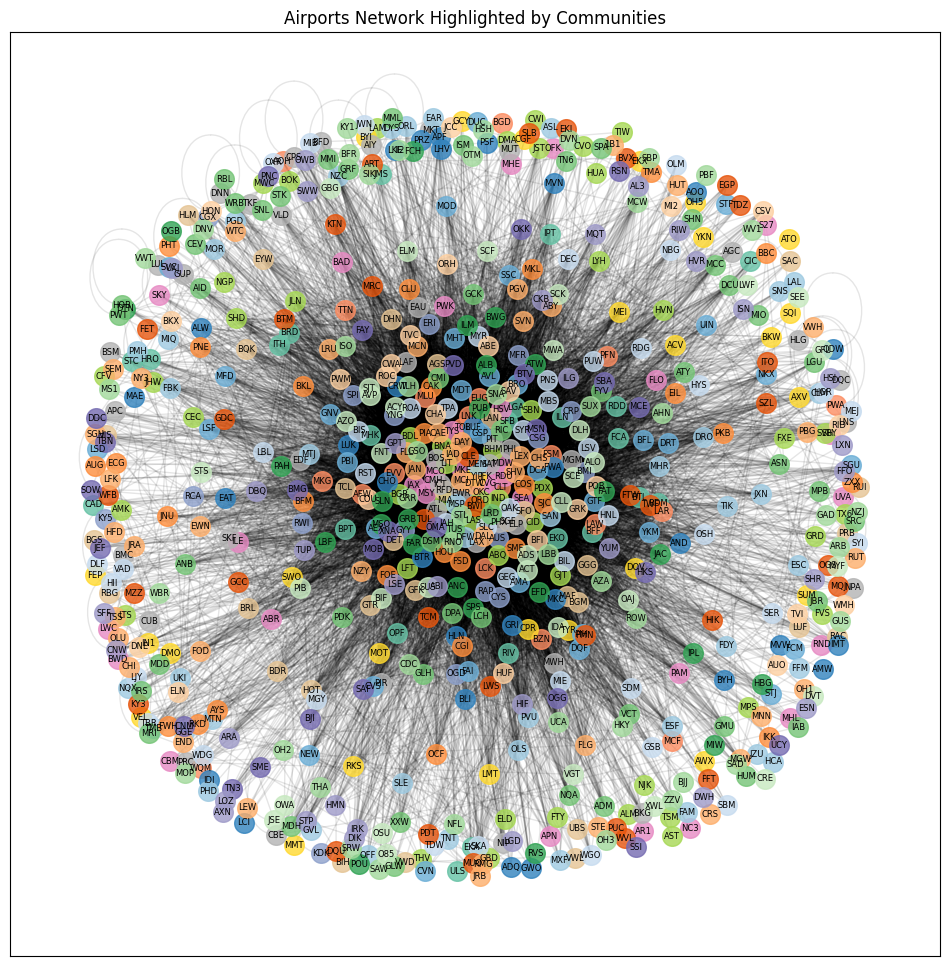

In [ ]:
analyze_communities(adjacency_list, 'Eugene, OR', 'Los Angeles, CA')

**5.2. Ask a LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to suggest an alternative algorithm for extracting communities and explain the steps required to implement it. Then, implement this algorithm and compare its results with the current method you've chosen. Discuss the differences in the outcomes and analyze which approach you think is better, providing reasons for your choice.**

The following **promt** was used:

    Suggest a different algorithm to extract communities other than Louvain. Explain the steps required to implement it.

The **answer** is reported below:

<br>
**Label Propagation** is a fast and simple community detection algorithm that relies solely on the network's topology. The key idea is that each node adopts the most frequent label among its neighbors, and this process iterates until convergence.

**How It Works:**
- **Initialization:** Each node is assigned a unique label (usually its own ID). These labels represent the community that the node currently belongs to.

- **Propagation:** For each node, update its label by choosing the most common label among its neighbors. If there is a tie (multiple labels with the same frequency), one label is chosen randomly.

- **Iteration:** This process is repeated iteratively until the labels no longer change or until a maximum number of iterations is reached.

- **Termination:** The algorithm stops when no label changes during an iteration, meaning the communities have stabilized.
Nodes with the same label at the end of the process form a community.

In [ ]:
import random
from collections import defaultdict, Counter

def label_propagation(adj_list, max_iter=100):
    """
    Label Propagation Algorithm (LPA) for community detection.

    """

    # Initialize each node with a unique label
    labels = {airport: i for i, airport in enumerate(adj_list)}

    for i in range(max_iter):

        # Get a list of airports with random ordering
        airports = list(adj_list.keys())
        random.shuffle(airports)

        changes = 0

        for airport in airports:

            # Get labels of neighboring nodes
            neighbor_labels = [labels[neighbor] for neighbor in adj_list[airport]]

            if not neighbor_labels:
                continue

            # Find the most frequent label in the neighborhood
            most_common_label = Counter(neighbor_labels).most_common(1)[0][0]

            # Update label if necessary
            if labels[airport] != most_common_label:
                labels[airport] = most_common_label
                changes += 1

        # If no labels were updated, stop iterating (convergence)
        if changes == 0:
            break

    # Group nodes by their final label (forming communities)
    communities = defaultdict(list)
    for airport, label in labels.items():
        communities[label].append(airport)

    # Final community structure as a dictionary
    coms = {e:community for e, community in enumerate(list(communities.values()))}

    print (f" Total number of communities: {len(coms)}")
    for community, cities in coms.items():
        print(f"Community {community}: {', '.join(cities)}")


In [ ]:
label_propagation(adjacency_list)

 Total number of communities: 47
Community 0: MHK, EUG, MFR, SEA, PDX, LMT, SFO, LAX, EAT, YKM, EKO, SLE, GEG, RDD, LWS, AST, CLM, PDT, SJC, ACV, PUW, SMF, FLL, PHX, BFI, GGG, GTF, FAT, TUS, MWH, BIL, DFW, RBG, SLC, CPR, RDM, RNO, FBK, ANC, BIF, CIC, SAF, ABQ, FSM, LAS, DQF, ICT, AZA, DLH, CEC, OKC, SAN, STS, DRO, OAK, IAH, ELP, DBQ, HLN, TUL, OMA, ACT, BTM, AUS, PIA, CWA, PUB, FOE, COS, GJT, LBF, SPS, CYS, ABR, BRD, AMA, ROW, BIS, MSO, GCC, LBB, LBL, MAF, MSN, LNK, ALO, RFD, GRB, LSE, FCA, MKE, BLI, FOD, DSM, EAU, MCW, RAP, LIT, SHV, MCI, GFK, BFL, SAT, MSP, SGF, BFF, FSD, GRI, CID, FYV, SUX, GCK, BTR, IDA, SPI, SBA, CRP, DEC, ORD, BZN, PIR, MLU, YUM, MOT, GYY, FAR, RST, STL, BNA, EVV, MEM, JAN, MOD, CMI, SCK, IND, BMI, TWF, LRD, CAK, MTJ, CLE, CLL, DTW, ABI, DAY, CVG, JAC, CMH, SBN, FWA, AZO, HOU, RKS, BPT, PIH, SLN, UIN, LAW, TOL, RIW, BRO, SJT, PRB, SHR, MCE, GRK, VGT, CDC, PNC, HRO, WDG, RCA, BWD, DDC, PIT, ORH, ITH, ELM, BOS, ATL, MDW, PHL, GSO, FNT, BUF, EWR, BGR, CLT, JFK, SYR,

In this case, the number of communities identified is doubled.

In the context of a network of airports, **Louvain**, which optimizes the graph's division based on the density of connections, can be more accurate than **Label Propagation**, which instead relies on iterative label propagation.

**Louvain** optimizes modularity, which measures how well a graph can be divided into dense communities. This makes it more robust in detecting communities that truly reflect the network structure, in this case, airports connected by many routes.

---

## **Bonus Question - Connected Components on MapReduce**

**B.1.**

In [ ]:
!pip install pyspark

This program is designed to identify the connected components within a flight network using the MapReduce paradigm in PySpark. A connected component in this context refers to a group of airports where every pair of airports is connected either directly by a flight or indirectly through other airports.

The process involves iteratively propagating labels across a graph representation of the flight network until a stable state is reached. Each connected component is identified by a unique label shared among its constituent airports.

**Inputs**

1.	Flight Data: An RDD of tuples representing the flight network, where each tuple has the following structure:
	•	source_airport: The originating airport of a flight.
	•	destination_airport: The destination airport of a flight.
	•	flight_date: The date of the flight in the format YYYY-MM-DD.
2.	Start Date: The beginning of the date range for flights to be considered, formatted as YYYY-MM-DD.
3.	End Date: The end of the date range for flights to be considered, formatted as YYYY-MM-DD.

**Outputs**

The program returns a dictionary containing the following details:

*	Total Components: The number of connected components in the flight network.

*	Component Sizes: The size (number of airports) of each connected component.

* Largest Component: A list of airports in the largest connected component, along with its size.

This approach ensures scalable and efficient processing of large-scale flight networks by leveraging distributed computing and iterative refinement of graph labels.

In [ ]:
from pyspark.sql import SparkSession
from datetime import datetime

def flights_in_range(record, start_date, end_date):
    """Filter flights by date range."""
    source, destination, flight_date = record
    try:
        date = datetime.strptime(flight_date, "%Y-%m-%d")
        return start_date <= date <= end_date
    except ValueError:
        return False

def identify_connected_components(flight_data, start_date, end_date):

    # Filter flights within the date range
    valid_flights = flight_data.filter(lambda record: flights_in_range(record, start_date, end_date))

    if valid_flights.isEmpty():
        print("No flights found in the specified date range.")
        return {
            "total_components": 0,
            "component_sizes": [],
            "largest_component": None
        }

    # Simulate an undirected graph by adding connections in both directions
    edges = valid_flights.flatMap(lambda flight: [(flight[0], flight[1]), (flight[1], flight[0])]).distinct()

    # Initialize each airport as its own component
    airports = edges.flatMap(lambda edge: [edge[0], edge[1]]).distinct()
    airport_labels = airports.map(lambda airport: (airport, airport))

    # Function for distributing labels across edges in the graph
    def update_labels(edge, current_labels):
        src, dst = edge
        return [(src, min(current_labels[src], current_labels[dst])),
                (dst, min(current_labels[src], current_labels[dst]))]

    # Perform label propagation until labels stabilize
    def propagate_labels(current_labels):
        label_map = current_labels.collectAsMap()  # Create a dictionary of current labels
        updated_labels = edges.flatMap(lambda edge: update_labels(edge, label_map)).reduceByKey(min)
        return updated_labels

    previous_labels = airport_labels
    while True:
        next_labels = propagate_labels(previous_labels)
        if next_labels.subtract(previous_labels).isEmpty():
            break
        previous_labels = next_labels

    # Group airports by their final component label
    components = previous_labels.map(lambda pair: (pair[1], pair[0])).groupByKey().mapValues(list)

    # Analyze components
    total_components = components.count()
    sizes = components.mapValues(len).collect()
    largest_component = components.mapValues(len).max(lambda x: x[1])

    return {
        "total_components": total_components,
        "component_sizes": sizes,
        "largest_component": largest_component
    }
def get_date_input(prompt):
    """Prompt the user for a date in 'YYYY-MM-DD' format and validate it."""
    while True:
        try:
            date_input = input(prompt)
            return datetime.strptime(date_input, "%Y-%m-%d")
        except ValueError:
            print("Invalid date format. Please enter the date in 'YYYY-MM-DD' format.")



In [ ]:
if __name__ == "__main__":
    # Initialize SparkSession
    spark = SparkSession.builder.appName("FlightNetworkAnalysis").getOrCreate()
    pyspark_df = spark.createDataFrame(dataset)

    # Prompt the user for start and end dates in the correct format
    print("Please enter the date range for analysis in 'YYYY-MM-DD' format.")
    start_date = get_date_input("Enter start date: ")
    end_date = get_date_input("Enter end date: ")

    # Convert the DataFrame to an RDD with the correct columns
    flight_rdd = pyspark_df.rdd.map(lambda row: (row.Origin_airport, row.Destination_airport, row.Fly_date))

    # Call the function and analyze connected components
    results = identify_connected_components(flight_rdd, start_date, end_date)

    # Print the results
    print("Total connected components:", results["total_components"])
    print("Sizes of all components:", results["component_sizes"])
    print("Largest connected component:", results["largest_component"])

Please enter the date range for analysis in 'YYYY-MM-DD' format.
Enter start date: 2002-01-01
Enter end date: 2002-01-01
Total connected components: 2
Sizes of all components: [('ABE', 289), ('BIF', 2)]
Largest connected component: ('ABE', 289)


**B.2.**

In [ ]:
import time

# Start timing the MapReduce implementation
start_time = time.time()
mapreduce_results = identify_connected_components(flight_rdd, start_date, end_date)
mapreduce_time = time.time() - start_time

# Display the results and execution time
print("MapReduce Execution Time:", mapreduce_time)
print("MapReduce Results:")
print("Total connected components:", mapreduce_results["total_components"])
print("Component sizes:", mapreduce_results["component_sizes"])
print("Largest connected component:", mapreduce_results["largest_component"])

MapReduce Execution Time: 173.88938355445862
MapReduce Results:
Total connected components: 2
Component sizes: [('ABE', 289), ('BIF', 2)]
Largest connected component: ('ABE', 289)


In [ ]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame

from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/ADM-HW5')

!pip install pyspark==3.1.3
!wget https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark 3.1.3-s_2.12/graphframes-0.8.3-spark3.5-s_2.12.jar -P /content/



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2024-12-29 21:32:09--  https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark
Resolving repos.spark-packages.org (repos.spark-packages.org)... 18.172.170.23, 18.172.170.17, 18.172.170.21, ...
Connecting to repos.spark-packages.org (repos.spark-packages.org)|18.172.170.23|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-12-29 21:32:09 ERROR 404: Not Found.

--2024-12-29 21:32:09--  http://3.1.3-s_2.12/graphframes-0.8.3-spark3.5-s_2.12.jar
Resolving 3.1.3-s_2.12 (3.1.3-s_2.12)... failed: Name or service not known.
wget: unable to resolve host address ‘3.1.3-s_2.12’


In [ ]:
pip install graphframes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 11.3 MB/s eta 0:00:00


In [ ]:
from graphframes import GraphFrame

In [ ]:
# Initialize the Spark session
spark = SparkSession.builder \
        .appName("GraphFramesExample") \
        .config("spark.jars.packages", "graphframes-0.8.3-spark3.5-s_2.12.jar") \
        .getOrCreate()

#Set checkpoint directory for GraphFrames
spark.sparkContext.setCheckpointDir("/tmp/checkpoints")

#Identify connected components using GraphFrames
def graphframes_connected_components(pyspark_df, start_date, end_date):

    # Filter the DataFrame by date range
    filtered_df = pyspark_df.filter((pyspark_df.Fly_date >= start_date) & (pyspark_df.Fly_date <= end_date))

    # Create vertices and edges for the graph
    edges = filtered_df.select("Origin_airport", "Destination_airport").withColumnRenamed("Origin_airport", "src").withColumnRenamed("Destination_airport", "dst")
    vertices = edges.select("src").union(edges.select("dst")).distinct().withColumnRenamed("src", "id")

    # Create the GraphFrame
    g = GraphFrame(vertices, edges)

    # Compute connected components
    result = g.connectedComponents()

    # Analyze the results
    components = result.groupBy("component").count().collect()
    largest_component = result.groupBy("component").count().orderBy("count", ascending=False).first()

    return {
        "total_components": len(components),
        "component_sizes": components,
        "largest_component": largest_component
    }

# Start timing the GraphFrames implementation
start_time = time.time()
graphframes_results = graphframes_connected_components(pyspark_df, "2002-01-01", "2002-01-01")
graphframes_time = time.time() - start_time

# Display the results and execution time
print("GraphFrames Execution Time:", graphframes_time)
print("GraphFrames Results:")
print("Total connected components:", graphframes_results["total_components"])
print("Component sizes:", graphframes_results["component_sizes"])
print("Largest connected component:", graphframes_results["largest_component"])

The results fron the MapReduce Implementation	and the GraphFrames Implementation are the same but the running time is very different. By using GraphFrames in fact the running time is higher.

---

## **Algorithmic Question (AQ)**

#### **a) Write a pseudocode that describes the algorithm to find the cheapest route with at most k stops.**

In [ ]:
'''
Cheapestflight(n, flights, src, dst, k)
Input:
    n: Number of cities.
    flights: List of flights, where each flight is a triplet (u, v, cost).
    src: Starting city.
    dst: Destination city.
    k: Maximum number of stops allowed.
Output:
    Minimum cost to reach dst from src with at most k stops, or -1 if not possible.

1. Create a graph G as an adjacency list:
      For each flight (u, v, cost) in flights:
          Add (v, cost) to G[u].

2. Initialize arrays:
      dist(u) = ∞ for all u ∈ {0, ..., n-1}   // Distance to all cities is infinity.
      stops(u) = ∞ for all u ∈ {0, ..., n-1}  // Stops to all cities is infinity.
   Set dist(src) = 0                          // Distance to the source is 0.
   Set stops(src) = 0                         // Stops to the source is 0.

3. Create a priority queue H (using dist-values as keys):
      H = makequeue(V)
      Insert (src, cost=0, stops=0) into H.   // Start with the source city.

4. While H is not empty:
      (u, current_cost, stops_made) = deletemin(H)  // Extract the city with the smallest cost.

      // If we reach the destination, return the cost.
      if u == dst:
          return current_cost

      // Skip if stops exceed the limit.
      if stops_made > k:
          continue

      // Relax edges from the current city.
      For each (v, cost) in G[u]:  // For each neighbor of u:
          if dist(v) > current_cost + cost or stops_made + 1 < stops(v):
              dist(v) = current_cost + cost      // Update the distance to v.
              stops(v) = stops_made + 1          // Update the stops to v.
              Insert (v, dist(v), stops(v)) into H.

5. Return -1  // If the destination is not reachable within the stop constraint.
'''

#### **b) Implement the algorithm in Python and simulate the given test cases.**

The following pseudocode implements a modified version of Dijkstra’s algorithm to find the minimum cost of traveling between two cities, subject to a maximum number of stops (k). This adaptation tracks both the cost and the number of stops for each path, ensuring that paths exceeding k stops are skipped. It uses a priority queue to prioritize paths with lower costs while efficiently managing the constraints.

In [ ]:
import heapq
from collections import defaultdict

def Cheapestflight(n, flights, src, dst, k):
    # Step 1: Build the adjacency list
    graph = defaultdict(list)
    for u, v, cost in flights:
        graph[u].append((v, cost))

    # Step 2: Initialize distance and stops arrays
    dist = [float('inf')] * n
    stops = [float('inf')] * n
    dist[src] = 0
    stops[src] = 0

    # Step 3: Priority queue (current_city, current_cost, stops_made)
    pq = [(0, src, 0)]

    while pq:
        current_cost, current_city, stops_made = heapq.heappop(pq)

        # If destination is reached, return the cost
        if current_city == dst:
            return current_cost

        # Skip if stops exceed the limit
        if stops_made > k:
            continue

        # Relax the edges from the current city
        for neighbor, cost in graph[current_city]:
            new_cost = current_cost + cost
            if new_cost < dist[neighbor] or stops_made + 1 < stops[neighbor]:
                dist[neighbor] = new_cost
                stops[neighbor] = stops_made + 1
                heapq.heappush(pq, (new_cost, neighbor, stops_made + 1))

    return -1

# --- Input Section ---
if __name__ == "__main__":
    print("Enter the number of cities (n):")
    n = int(input().strip())

    print("Enter the number of flights:")
    num_flights = int(input().strip())

    print("Enter the flights as 'u v cost' (one per line):")
    flights = []
    for _ in range(num_flights):
        u, v, cost = map(int, input().strip().split())
        flights.append((u, v, cost))

    print("Enter the source city (src):")
    src = int(input().strip())

    print("Enter the destination city (dst):")
    dst = int(input().strip())

    print("Enter the maximum number of stops allowed (k):")
    k = int(input().strip())

    # Call the function and print the result
    result = Cheapestflight(n, flights, src, dst, k)
    print(f"The cheapest price is: {result}")

Enter the number of cities (n):
3
Enter the number of flights:
3
Enter the flights as 'u v cost' (one per line):
0 1 100
1 2 100
0 2 500
Enter the source city (src):
0
Enter the destination city (dst):
2
Enter the maximum number of stops allowed (k):
1
The cheapest price is: 200


#### **c) Analyze the algorithm's efficiency. Provide its time complexity and space complexity, and explain whether it is efficient for large graphs (e.g., n > 100).**

#### **Time Complexity**
1. **Graph Construction**:
   - The adjacency list for the graph is built from the input list of flights. Each flight is processed once, which takes $O(E)$, where $E$ is the number of flights.

2. **Priority Queue Operations**:
   - The algorithm uses a priority queue to manage paths, prioritizing the lowest-cost paths.
   - Each city (node) can be visited up to $k+1$ times because paths with fewer stops are revisited to check for cheaper routes. For each visit:
     - The `deletemin` operation to extract the minimum-cost element from the heap takes $O(\log P)$, where $P$ is the number of elements in the heap (bounded by the number of flights, $E$).
     - For every neighbor of the current city, a `heappush` operation is performed, also taking $O(\log P)$.

   - In the worst case:
     - All $E$ edges are processed $k+1$ times, leading to $O((k+1) \cdot E)$ heap insertions.
     - Each insertion and deletion from the heap takes $O(\log E)$.

   - Total priority queue operations cost:
     $O((k+1) \cdot E \cdot \log E)$

3. **Overall Time Complexity**:
   - Combining graph construction and priority queue operations:
     $O(E + (k+1) \cdot E \cdot \log E) \approx O(k \cdot E \cdot \log E)$
     (since $k+1$ dominates the constant overhead).

---

#### **Space Complexity**
1. **Graph Representation**:
   - The adjacency list requires $O(E)$ space to store all flights.

2. **Priority Queue**:
   - The priority queue stores up to $O(E)$ elements in the worst case, as each flight could represent a potential path.

3. **Distance and Stops Arrays**:
   - Two arrays of size $n$ ($n$ is the number of cities) are used to track the minimum cost and stops for each city. This requires $O(n)$ space.

4. **Overall Space Complexity**:
   $O(E + n)$
   (dominated by $E$ if the graph is dense).

---

#### **Summary**

- **Time Complexity**:  
  $O(k \cdot E \cdot \log E)$

- **Space Complexity**:  
  $O(E + n)$

This makes the algorithm efficient for sparse graphs (small $E$) and moderate $k$, but performance can degrade for very dense graphs or large $k$.

#### **d) Optimize the algorithm to handle larger graphs. Provide an updated pseudocode and analyze the computational complexity of your optimization.**

To handle larger graphs efficiently, the following key improvements were made:
1.	Memory-Efficient visited Dictionary:
 Tracks only the minimum cost and stops for each node, reducing memory usage.
2.	Path Constraints:
 A new path is processed only if it is either new or cheaper than the previously stored one for that node and stop combination, pruning unnecessary paths.
3.	Queue Redundancy Check:
 Before adding a path to the queue, it is checked to ensure no duplicate or redundant paths are inserted, avoiding unnecessary computations.

In [ ]:
import heapq
from collections import defaultdict

def optimizedDijkstraWithConstraints(n, flights, src, dst, k):
    graph = defaultdict(list)
    for u, v, cost in flights:
        graph[u].append((v, cost))

    pq = [(0, src, 0)]  # (current_cost, current_city, stops_made)
    visited = {}

    while pq:
        current_cost, current_city, stops_made = heapq.heappop(pq)

        if current_city == dst:
            return current_cost
        if stops_made > k:
            continue
        if (current_city, stops_made) in visited and visited[(current_city, stops_made)] <= current_cost:
            continue

        visited[(current_city, stops_made)] = current_cost
        for neighbor, cost in graph[current_city]:
            new_cost = current_cost + cost
            if (neighbor, stops_made + 1) not in visited or new_cost < visited.get((neighbor, stops_made + 1), float('inf')):
                heapq.heappush(pq, (new_cost, neighbor, stops_made + 1))

    return -1

---
#### Complexity
- Time Complexity: $O(k \cdot E \cdot \log E)$, where $k$ is the maximum stops, and $E$ is the number of flights.
- Space Complexity: $O(E + n \cdot k)$, where $n$ is the number of cities.

---

#### Summary

This optimized algorithm improves scalability by pruning unnecessary paths, reducing memory usage, and avoiding redundant queue entries, making it suitable for larger graphs.

#### **e) Ask LLM (e.g., ChatGPT) for an optimized version of your algorithm. Compare its solution to yours in terms of performance, time complexity, and correctness.**

To handle larger graphs and optimize performance, Chat suggest to leverage the Bellman-Ford algorithm with constraints. This approach works well because it iterates up to  k+1  times and efficiently handles negative cycles and costs (if applicable).

Here’s the optimized pseudocode and analysis.
Updated Pseudocode
1.	Initialize distances:
  -	Use a 2D array dp where dp[i][j] represents the minimum cost to reach city  i  with  j  stops.
2.	Base cases:
	-	Set dp[src][0] = 0 (cost to start city is 0 with no stops).
	-	For all other cities, initialize dp[i][j] = inf.
3.	Iterate up to  k+1 :
	-	For each stop  j  (from 1 to  k+1 ):
	-	Iterate over all flights  (u, v, cost) :
	-	Relax the edge: If dp[u][j-1] + cost < dp[v][j], update dp[v][j].
4.	Find the minimum cost:
	-	Return the minimum cost in dp[dst][0...k+1].
	-	If no valid path exists, return -1.

---
Efficiency Analysis
1.	Time Complexity:
	-	The outer loop iterates  k+1  times.
	-	For each iteration, we relax  E  edges (number of flights).
	-	Total time complexity: $ O((k+1) \cdot E)$ .
2.	Space Complexity:
	-	The DP table has size $ O(n \cdot (k+2))$ .
	-	Total space complexity:  $O(n \cdot k) $.

---
Performance Comparison

The optimized algorithm significantly reduces the time complexity compared to the priority queue method:

-	Old Algorithm:  $O(k \cdot E \cdot \log E) $

-	New Algorithm: $ O(k \cdot E) $

This improvement comes from eliminating the logarithmic overhead of the priority queue operations. However, the new algorithm may use slightly more space due to the DP table.